In [1]:
import matplotlib.pyplot as plt
# import scipy.stats as st
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

In [2]:
large_noise_wave = WaveGen(size=100).linear_phase().cos().amp(.5).t_noise(std=.01, dof=5).sample(1).samples.squeeze()
small_noise_wave = WaveGen(size=100).linear_phase().cos().amp(.5).t_noise(std=.05, dof=5).sample(1).samples.squeeze()
noise_wave = np.r_[large_noise_wave, small_noise_wave]

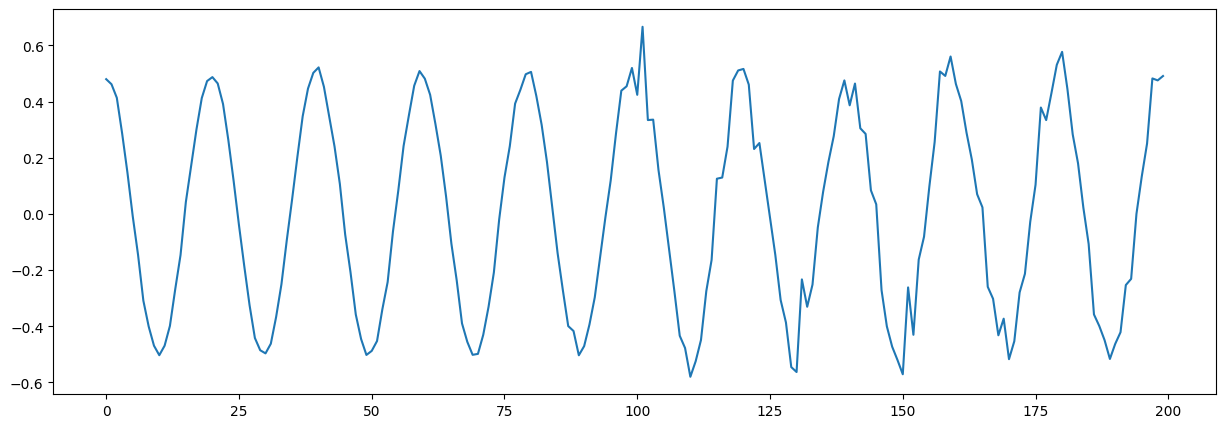

In [3]:
plt.figure(figsize=(15,5))
plt.plot(noise_wave)
plt.show()

In [22]:
class HarderSigmoid(nn.Module):
    def __init__(self, slope=400., bias=0.):
        super(HarderSigmoid, self).__init__()
        self.slope = slope
        self.bias = bias
        return

    def forward(self, x):
        return nn.functional.hardsigmoid(self.slope * x + self.bias)
    
class SineBinarySeparator(nn.Module):
    def __init__(self, input_dim=2000, output_dim=2000, sigmoid_slope=30, negative_slope=.5, dropout_p=.5, eps=1e-4, **optim_kwargs):
        super(SineBinarySeparator, self).__init__()
        self.eps = eps
        self.optim_kwargs = optim_kwargs
        
        self.input = nn.Linear(input_dim, output_dim)
#         self.activation = nn.ReLU()
#         self.activation = nn.LeakyReLU(negative_slope=negative_slope)
        self.activation = nn.Tanh()
        self.hidden = nn.Linear(output_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_p)
        self.hidden2 = nn.Linear(output_dim, input_dim)
        self.output = HarderSigmoid(slope=sigmoid_slope)
        return
        
    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        x = self.hidden(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden2(x)
#         hyperbolic_x = torch.tanh(x)
        return x

    def var_loss(self, output, x, bf=.1):
        """
        bf (Balance Factor) : float
        Decides how important the balance is to the loss function
        """
        zero_up = self.output(output)
        zero_down = self.output(-output)
        
        up_count = zero_up.sum()
        down_count = zero_down.sum()
    
        x = torch.square(x - x.mean())
        
        var_up = torch.sum(x * zero_up) / up_count
        var_down = torch.sum(x * zero_down) / down_count

        balance = torch.abs(up_count - down_count).unsqueeze(0)
    
        var_loss = torch.log(1 / torch.abs(var_up - var_down)).unsqueeze(0)
        bal_loss = bf * balance
        assert ~torch.isnan(var_loss), f'{var_up} | {var_down}'
        assert ~torch.isnan(bal_loss)
        return var_loss, bal_loss, up_count, down_count
        
    def mean_loss(self, hyperbolic_x, x):
        raise NotImplementedError
        hyper_detach = hyperbolic_x.detach()
        x_detach = x.detach()
#         zero_tensor = torch.zeros_like(hyperbolic_x)
        zero_up = torch.where(hyperbolic_x < 0, 1, 0)
        zero_down = torch.where(hyperbolic_x >= 0, 1, 0)
        up_count = torch.count_nonzero(zero_up)
        down_count = torch.count_nonzero(zero_down)
        mean_up = x[zero_up].mean()
        mean_down = x[zero_down].mean()
        return torch.log(1 / (mean_up - mean_down + self.eps)).unsqueeze(0)
    
    def configure_optimizer(self):
        optimizer = torch.optim.RMSprop(self.parameters(), **self.optim_kwargs)
        return optimizer
    
    def train(self, x, epochs=1000, batch_size=128, metric='variance', noise_dist='gaussian', noise_std=.05):
        if not hasattr(self, 'loss_items'):
            self.loss_items = list()
            self.custom_losses = list()
        else:
            self.loss_items.clear()
        optimizer = self.configure_optimizer()
        criterion = nn.MSELoss()
        for epoch in range(epochs // batch_size):
            losses = list()
            optimizer.zero_grad()
            for _ in range(batch_size):
                if noise_dist == 'constant':
                    noise = torch.randn(1) * noise_std
                elif noise_dist == 'gaussian':
                    noise = torch.randn(x.shape[0]) * noise_std         
                elif noise_dist is not None:
                    raise ValueError('Invalid noise identifier')
                    
                forward_x = x + noise
                assert x.requires_grad, x.shape
                hyperbolic_x = self.forward(forward_x)
                
                if metric == 'variance':
                    var_loss, bal_loss, up_count, down_count = self.var_loss(hyperbolic_x, forward_x)
                    loss = var_loss + bal_loss
                    self.custom_losses.append((var_loss.item(), bal_loss.item(), up_count.item(), down_count.item()))
                    if not hasattr(self, 'custom_names'):
                        self.custom_names = ['Variance Loss','Balance Loss','Up Count','Down Count']
                elif metric == 'mean':
                    loss = self.mean_loss(hyperbolic_x, forward_x)
                elif metric == 'jsd':
                    loss = self.jsd_loss(hyperbolic_x, forward_x)
                else:
                    raise ValueError('Invalid metric identifier')
                losses.append(loss)
            loss = torch.cat(losses, dim=0)
            self.loss_items.extend(loss.tolist())

            loss.mean().backward()
            optimizer.step()
        self.plot_output(hyperbolic_x, x)
        return
            
    def plot_loss(self, step=1, title=''):
        plt.figure(figsize=(16,8))
        sns.lineplot(self.loss_items[::step], dashes=False, label='Variance Difference Loss')
        plt.title(title)
        plt.legend()
        plt.show()
        return
    
    def plot_custom_loss(self, step=1, title=''):
        plt.figure(figsize=(16,8))
        assert len(self.custom_losses[0]) == len(self.custom_names), f'{len(self.custom_losses)} != {len(self.custom_names)}'
        for loss_items, name in zip(zip(*self.custom_losses), self.custom_names):
            print(name)
            assert hasattr(loss_items, '__len__'), loss_item
            sns.lineplot(loss_items[::step], dashes=False, label=name)
        plt.title(title)
        plt.legend()
        plt.show()
        return
    
    def plot_output(self, hyperbolic_x, x):
        hyperbolic_x = hyperbolic_x.detach().numpy()
        x = x.detach().numpy()
        up_mask = hyperbolic_x >= 0
        down_mask = hyperbolic_x < 0

        fig, ax = plt.subplots(figsize=(15,5))
        horizontal = np.linspace(0, len(hyperbolic_x) - 1, len(hyperbolic_x)).astype(np.int32)
        assert horizontal.shape == x.shape
        up_indices = horizontal[up_mask]
        down_indices = horizontal[down_mask]
        
        ax.hist(x[up_indices], color='orange', alpha=.4)
        ax.hist(x[down_indices], color='purple', alpha=.4)
        plt.show()
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(15,5))
        ax1.scatter(up_indices, x[up_indices], label='A')
        ax2.scatter(down_indices, x[down_indices], label='B')
        ax1.legend()
        ax2.legend()
        plt.show()
        return

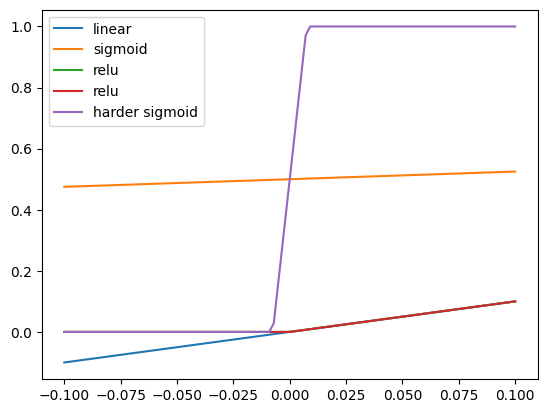

In [23]:
a = torch.linspace(-.1, .1, 100).detach()
x = a.numpy()
plt.plot(x, a.numpy(), label='linear')
plt.plot(x, torch.sigmoid(a).numpy(), label='sigmoid')
plt.plot(x, torch.relu(a).numpy(), label='relu')
plt.plot(x, torch.relu(a).numpy(), label='relu')
plt.plot(x, HarderSigmoid()(a).numpy(), label='harder sigmoid')
plt.legend()
plt.show()

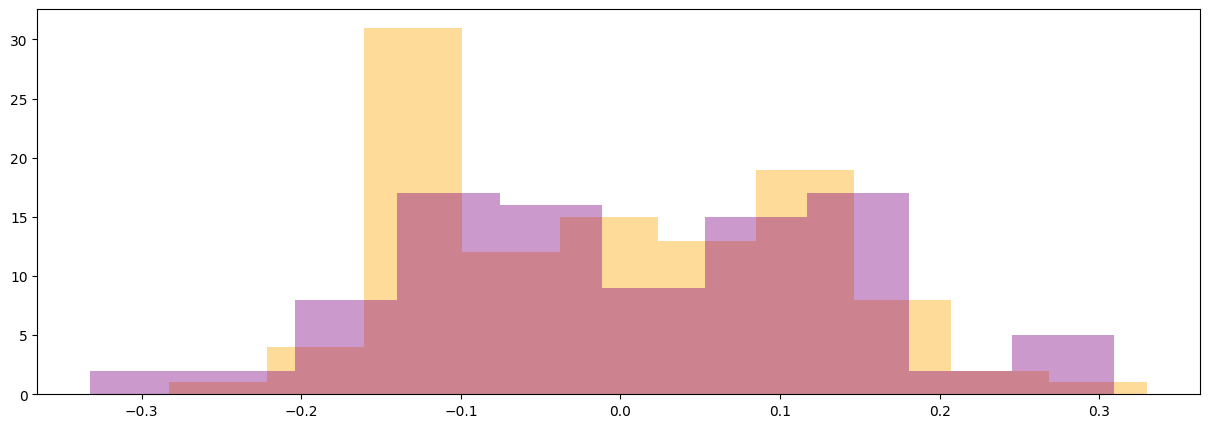

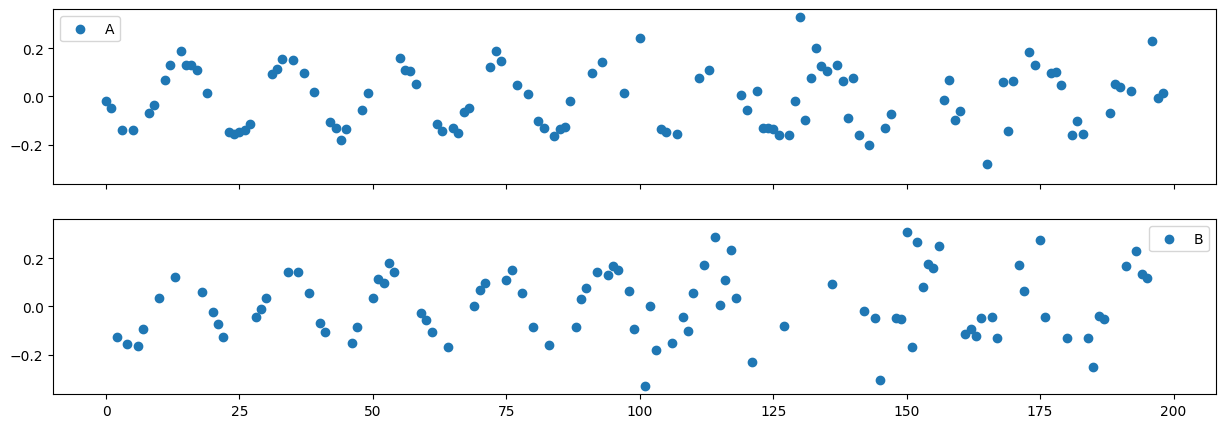

Variance Loss
Balance Loss
Up Count
Down Count


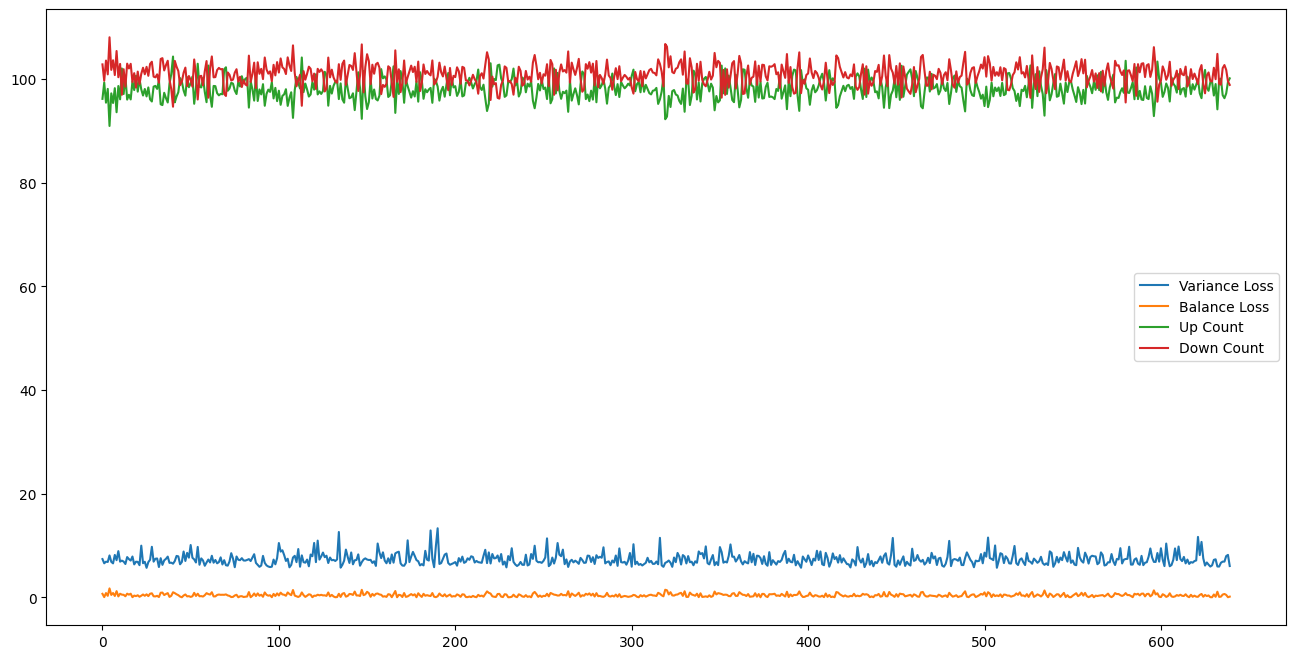

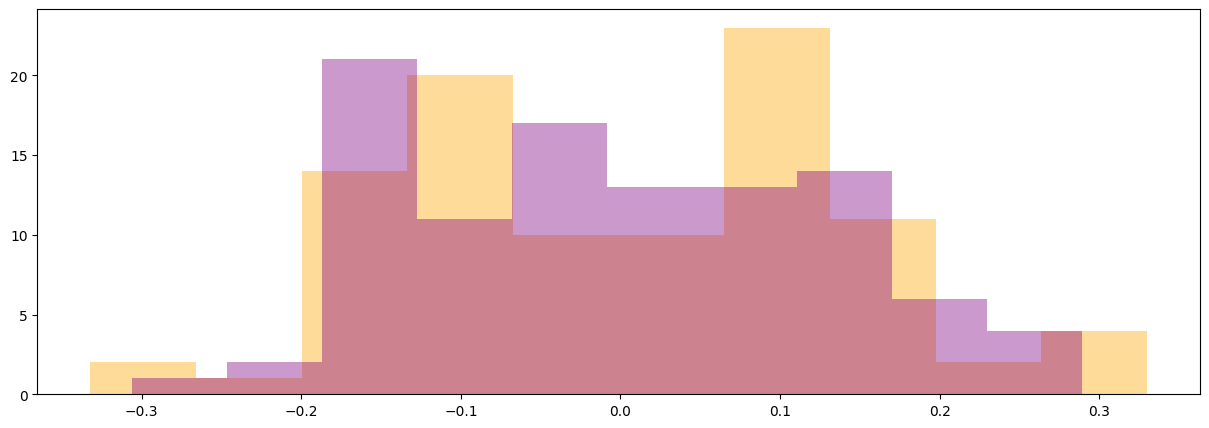

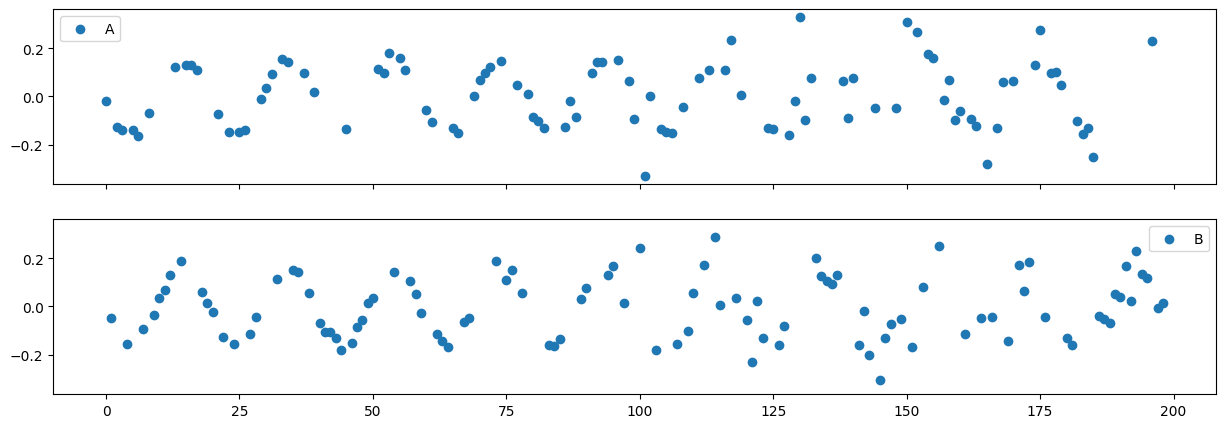

Variance Loss
Balance Loss
Up Count
Down Count


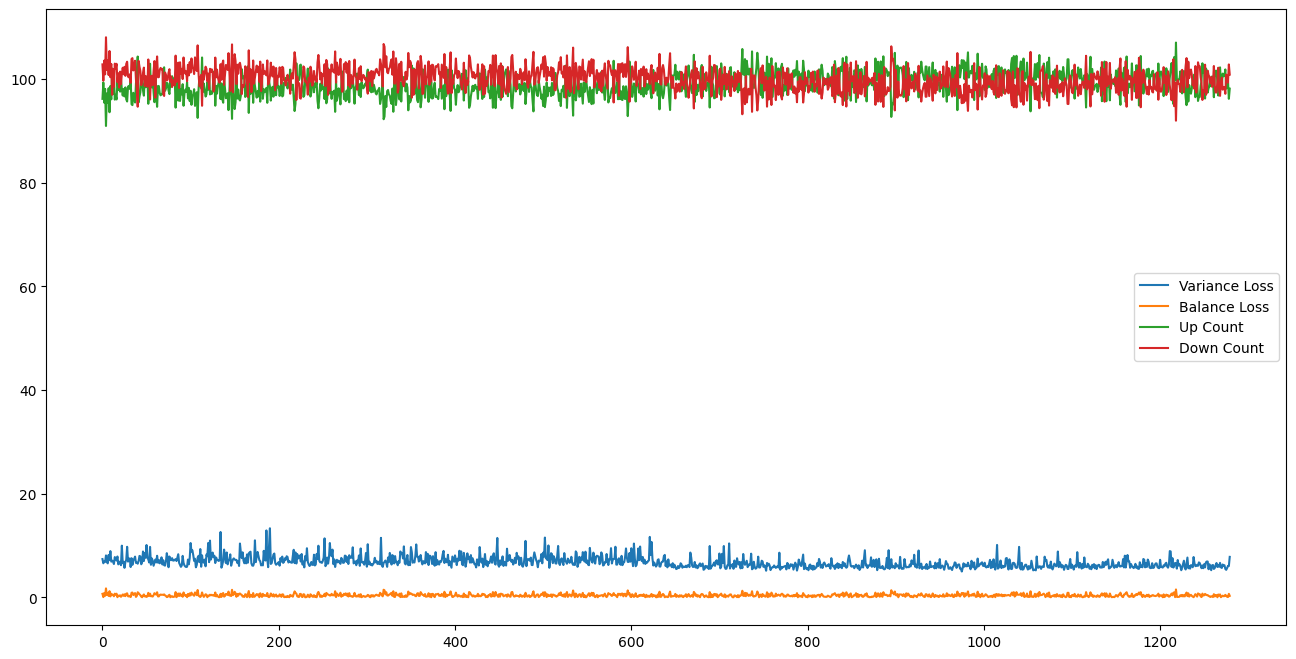

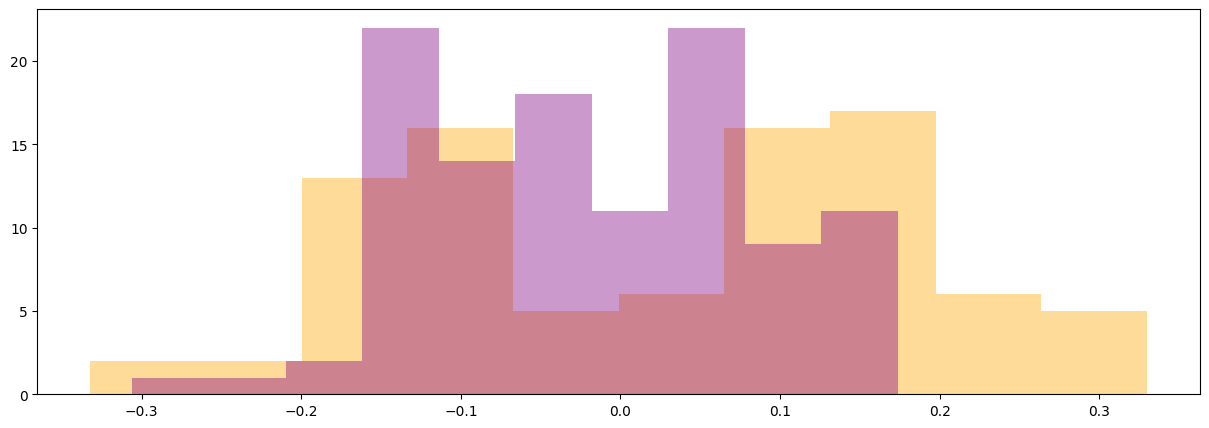

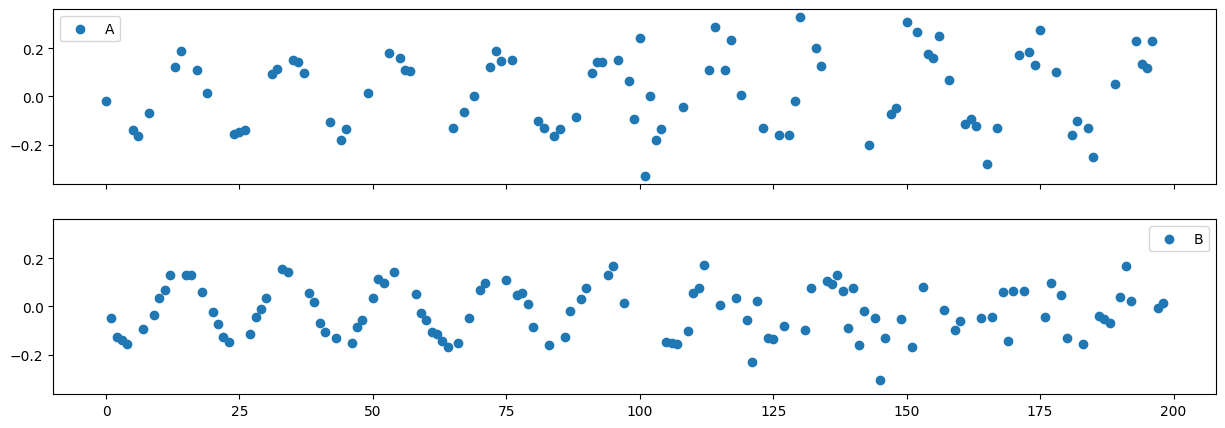

Variance Loss
Balance Loss
Up Count
Down Count


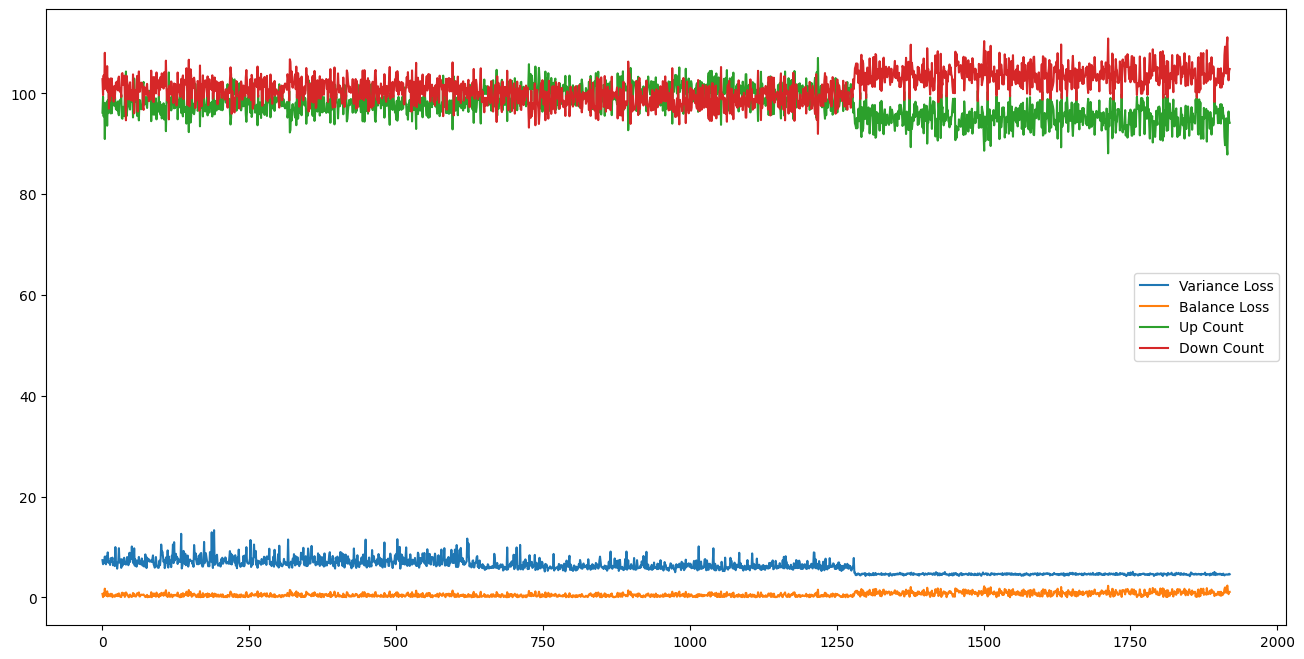

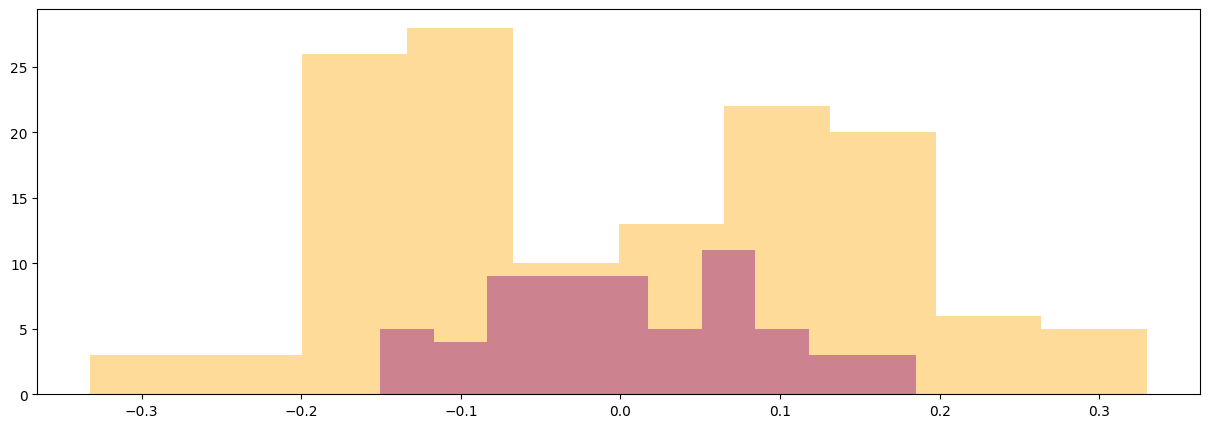

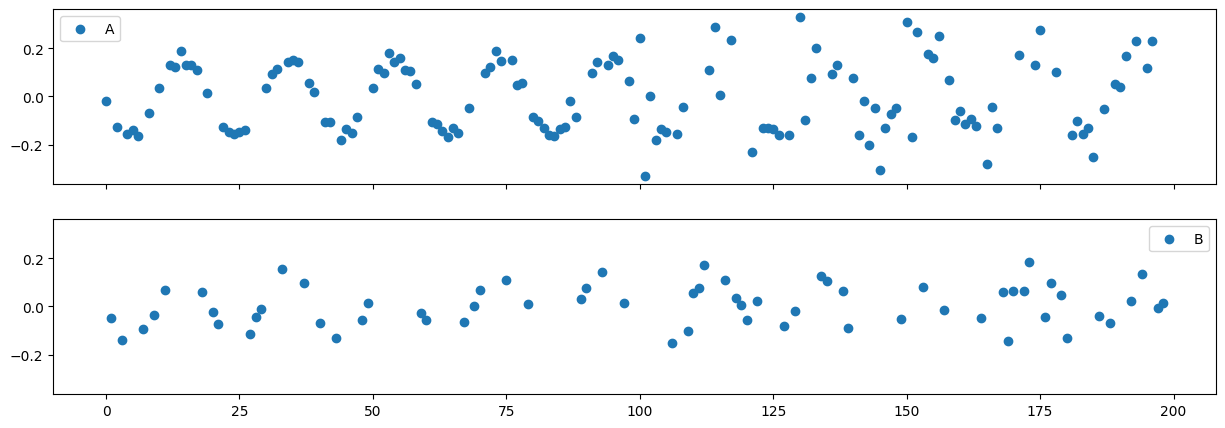

Variance Loss
Balance Loss
Up Count
Down Count


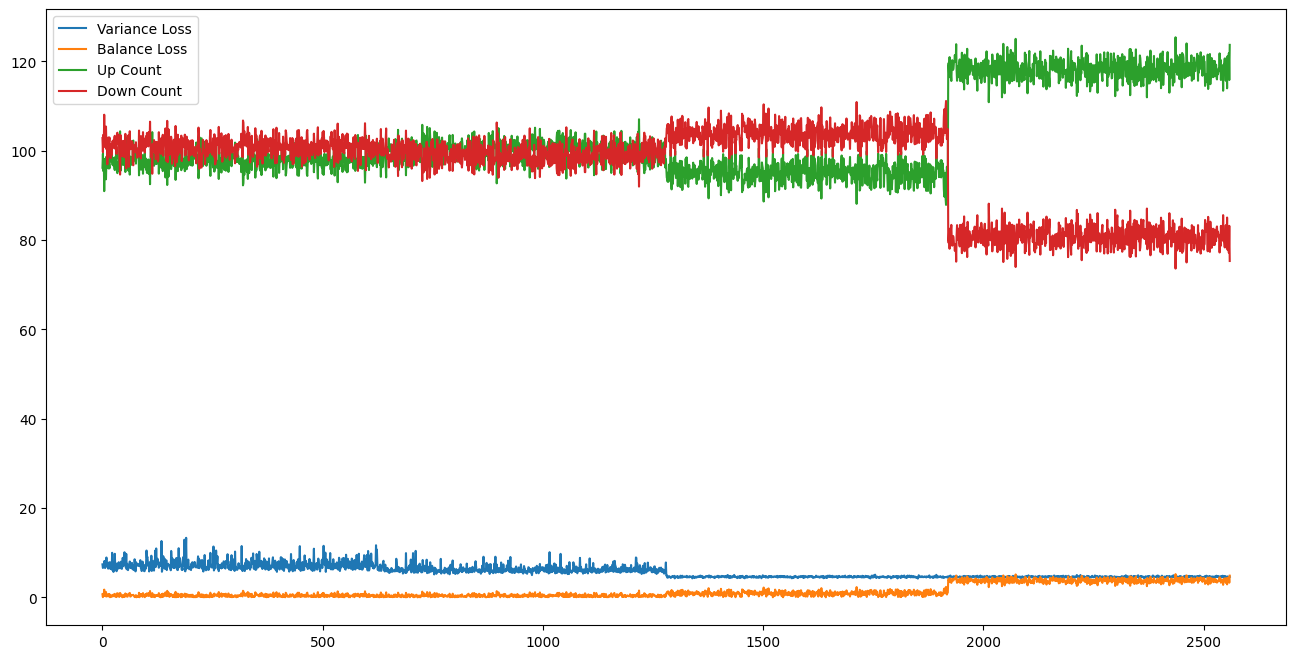

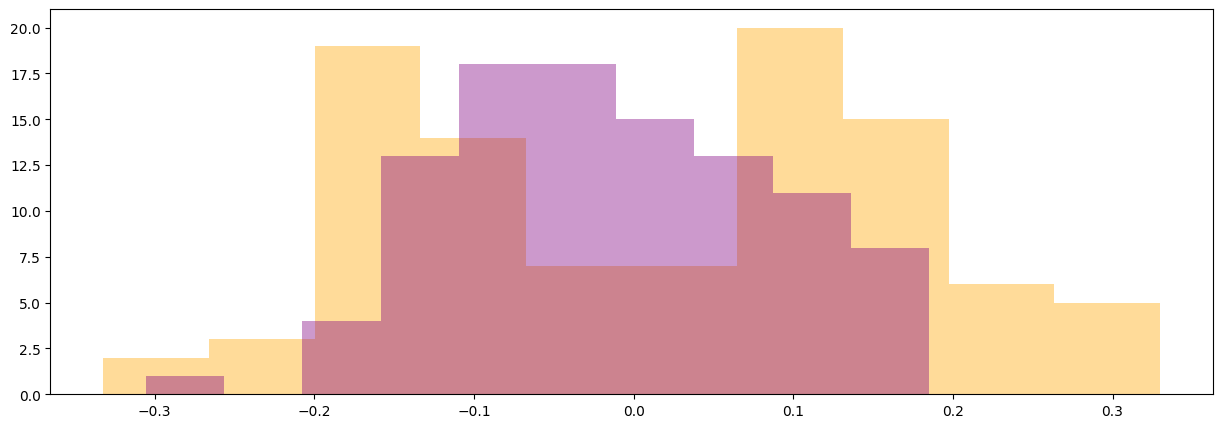

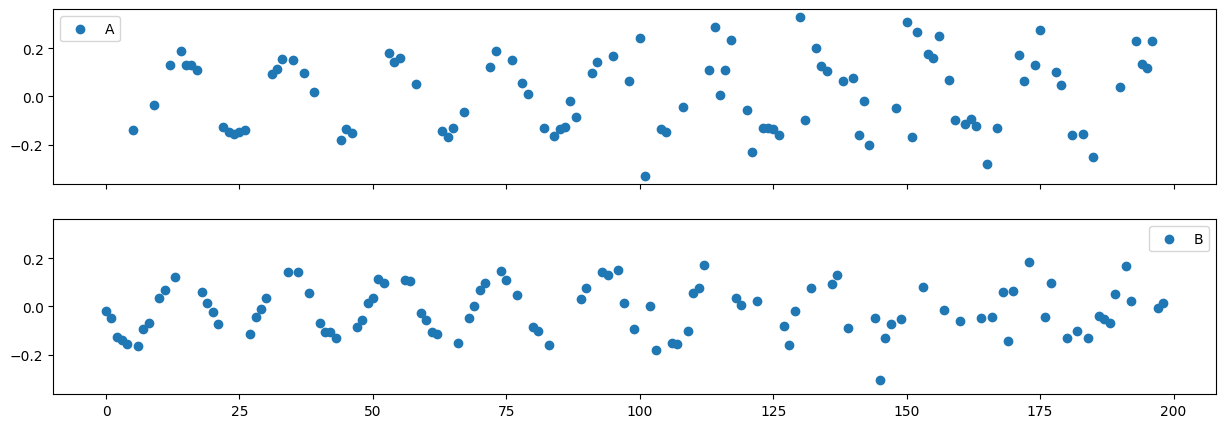

Variance Loss
Balance Loss
Up Count
Down Count


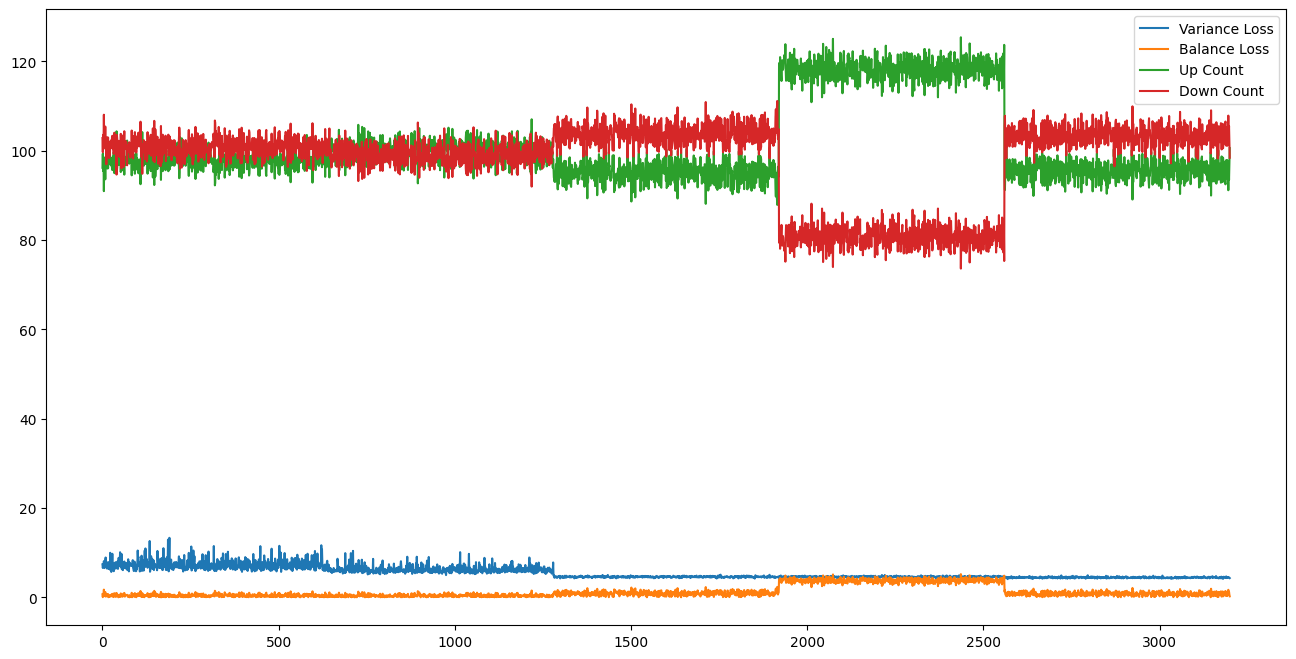

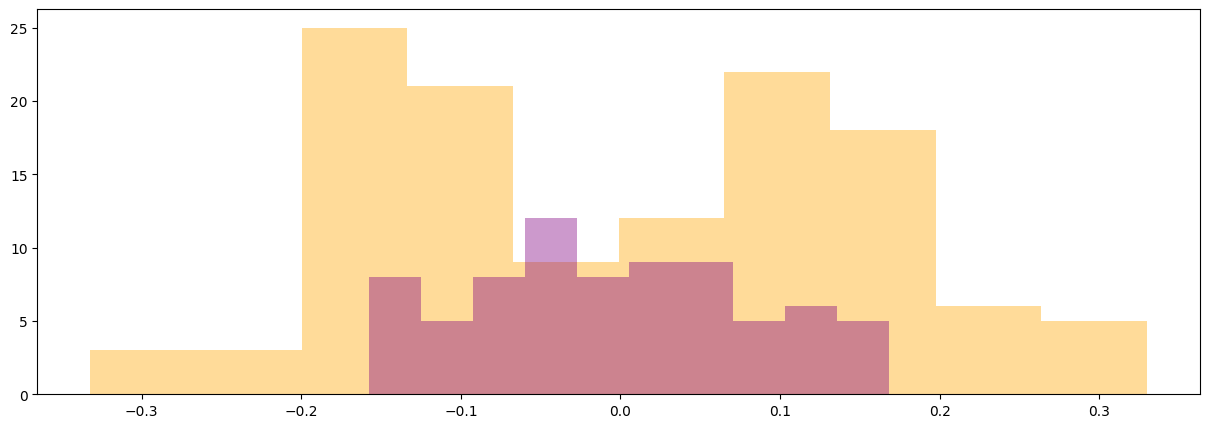

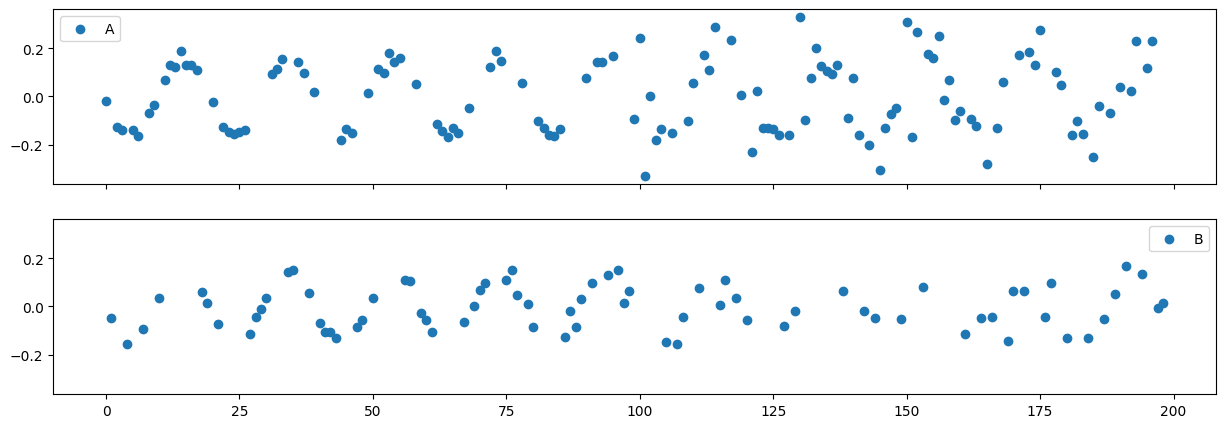

Variance Loss
Balance Loss
Up Count
Down Count


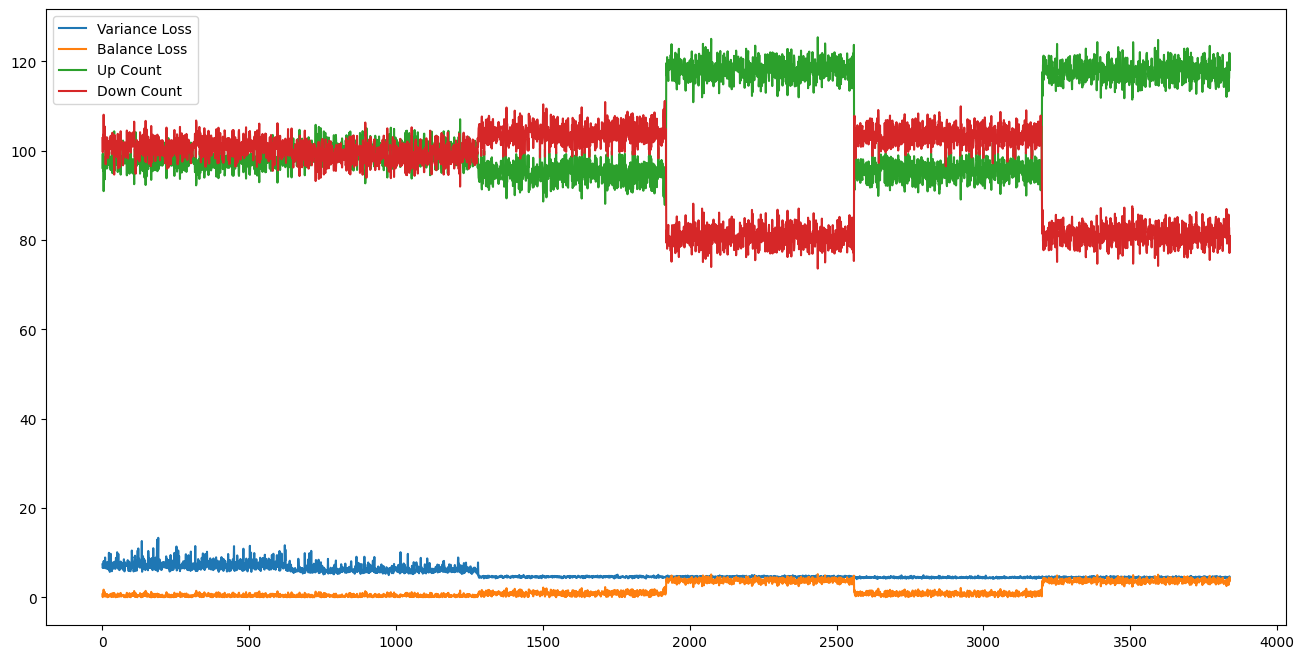

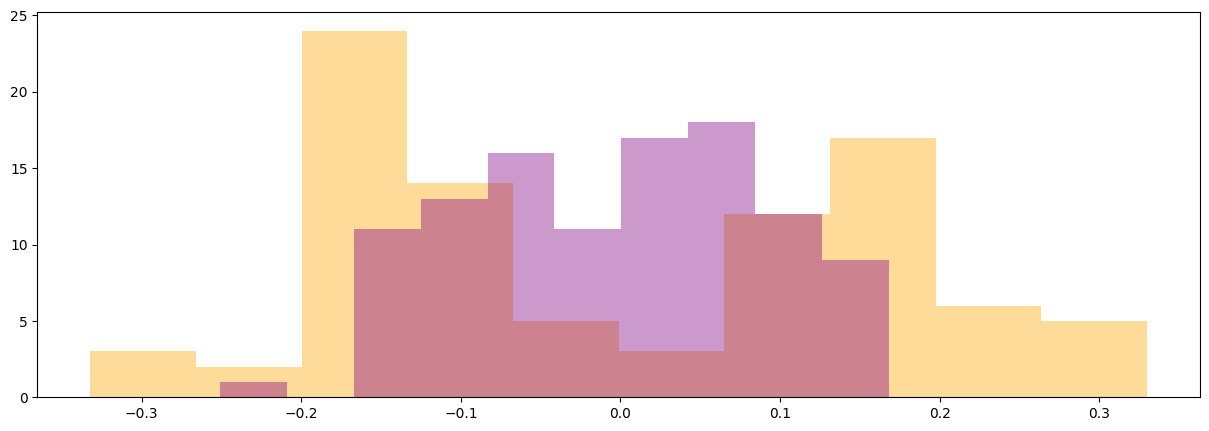

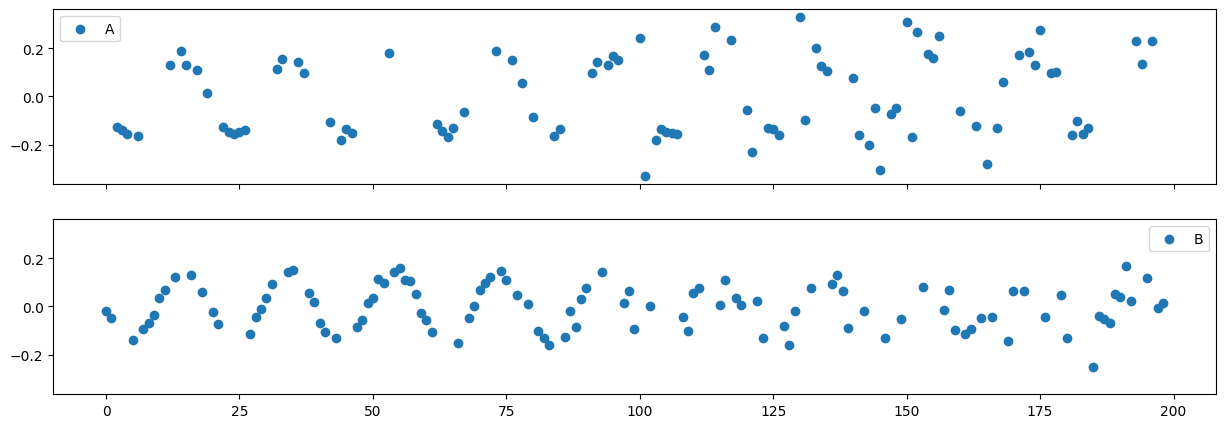

Variance Loss
Balance Loss
Up Count
Down Count


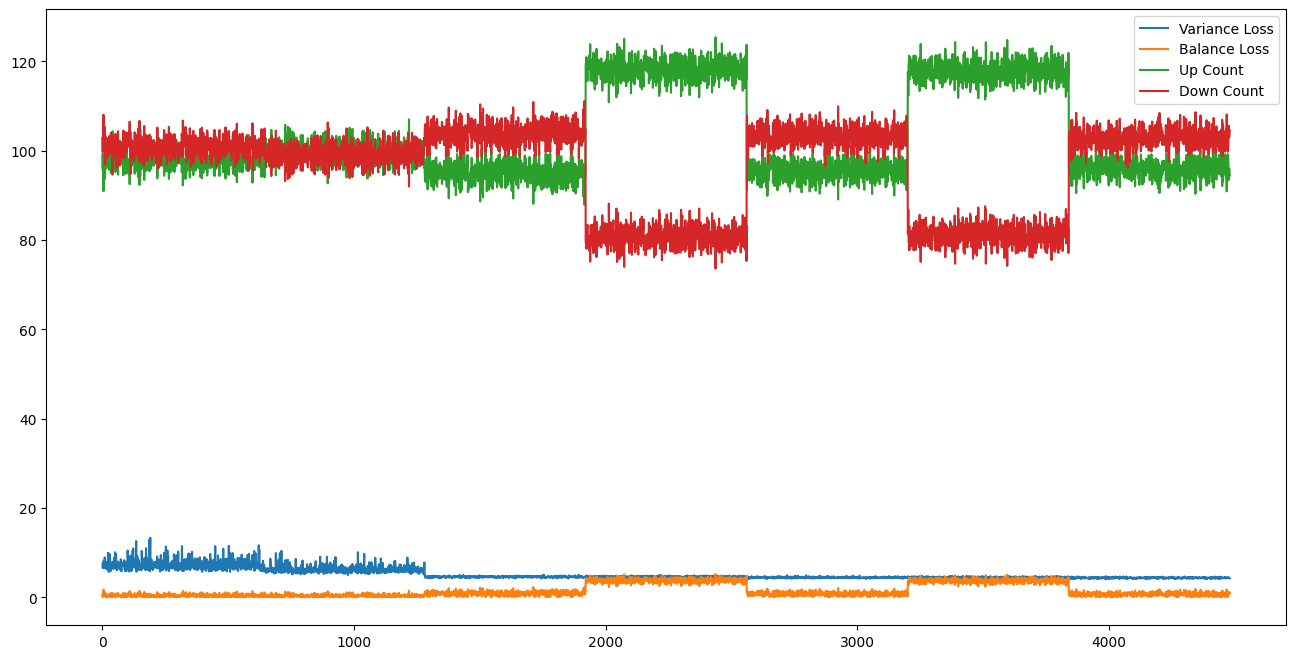

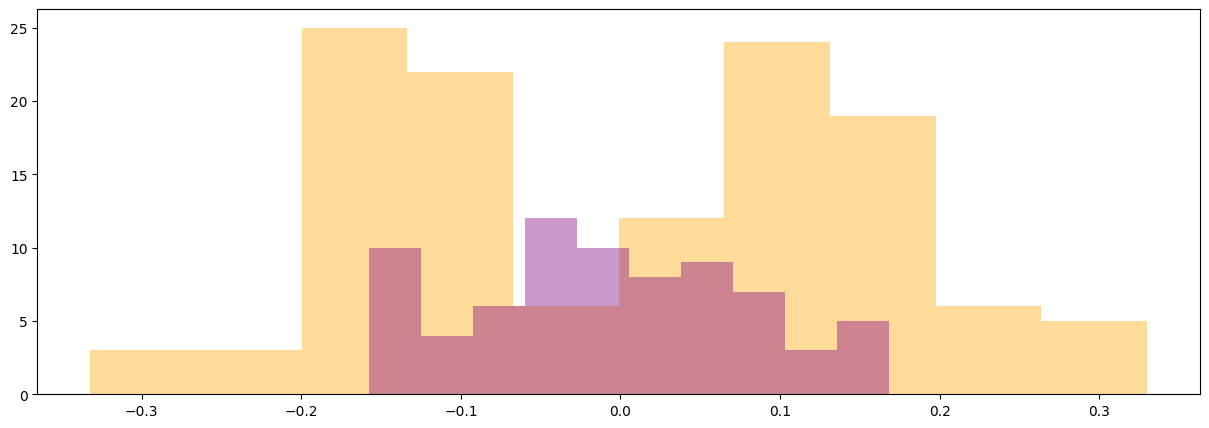

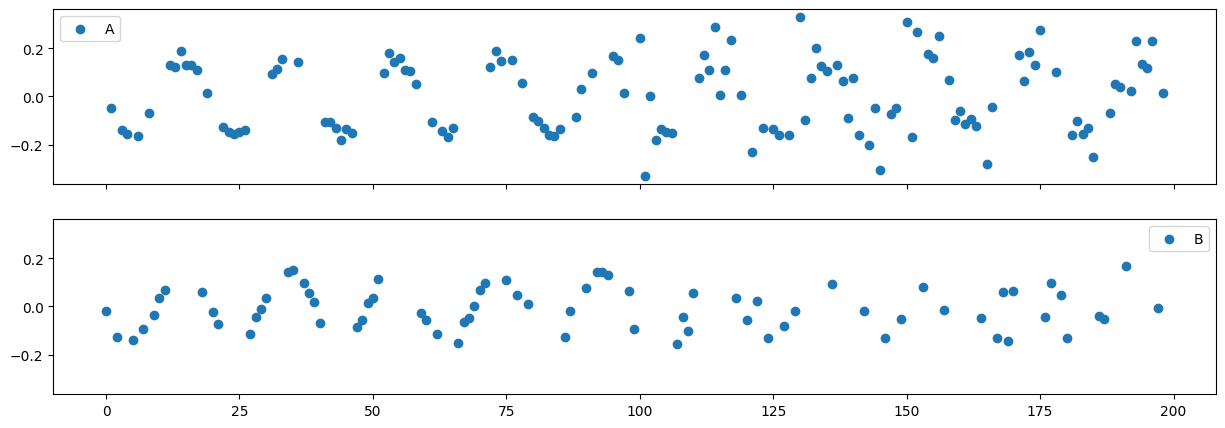

Variance Loss
Balance Loss
Up Count
Down Count


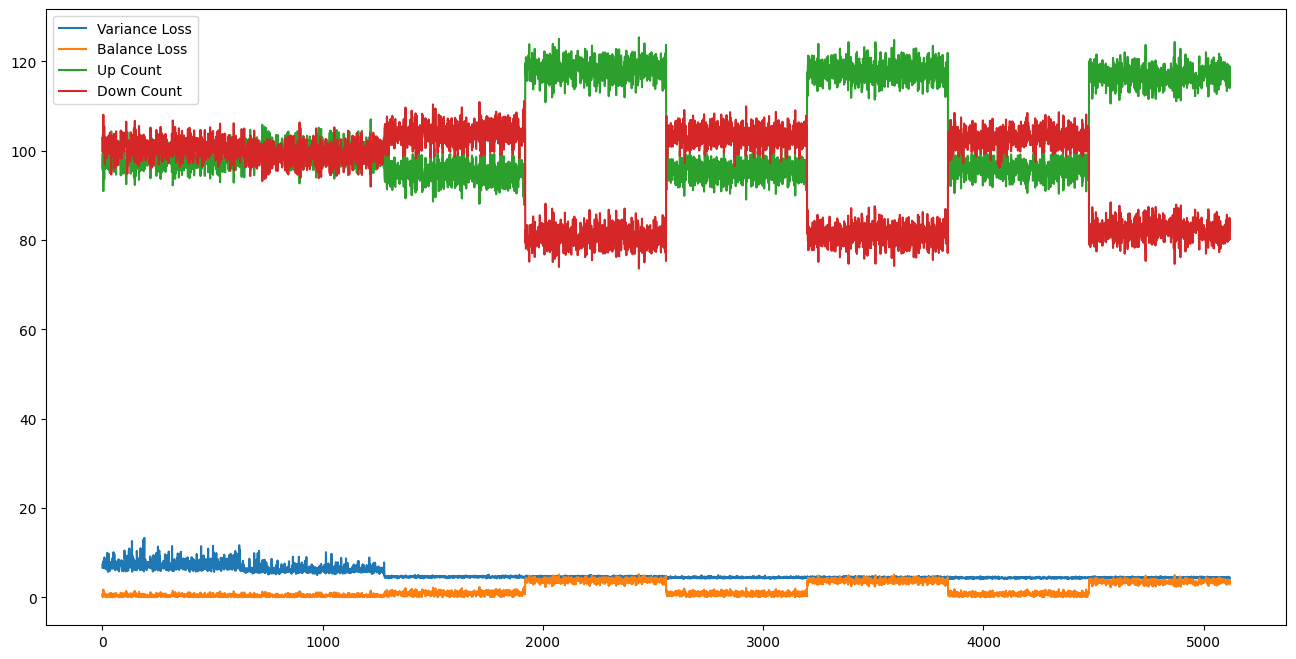

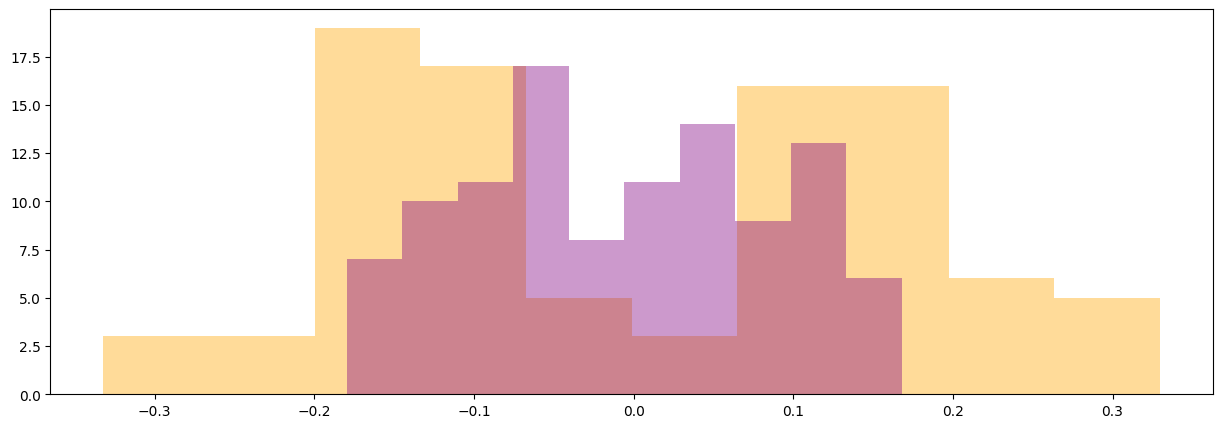

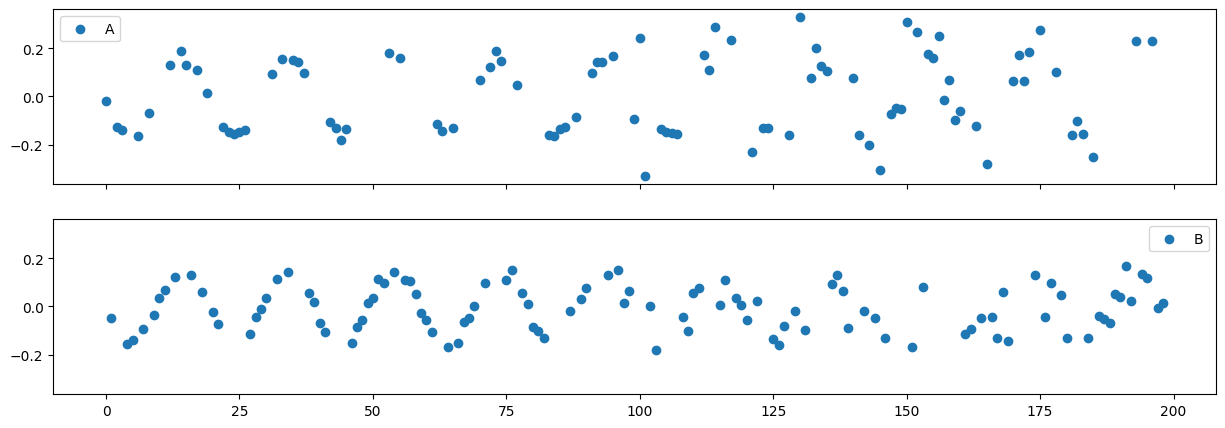

Variance Loss
Balance Loss
Up Count
Down Count


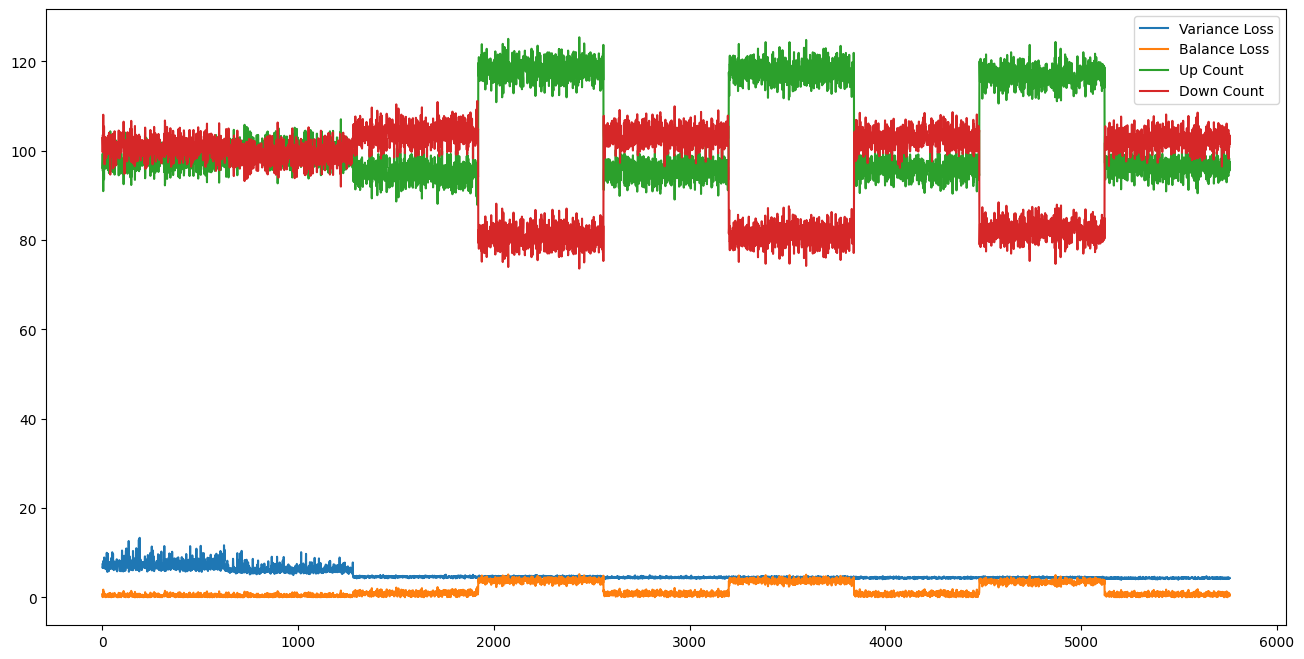

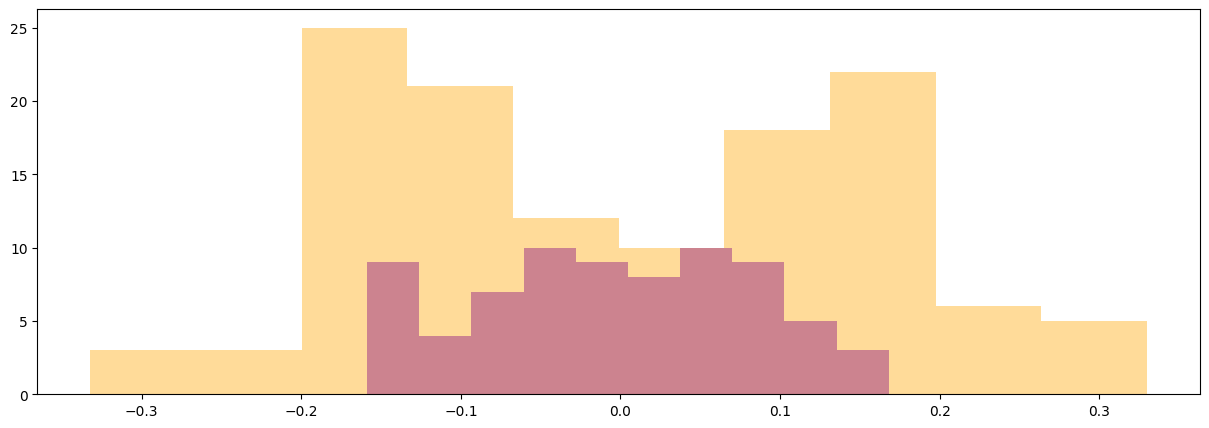

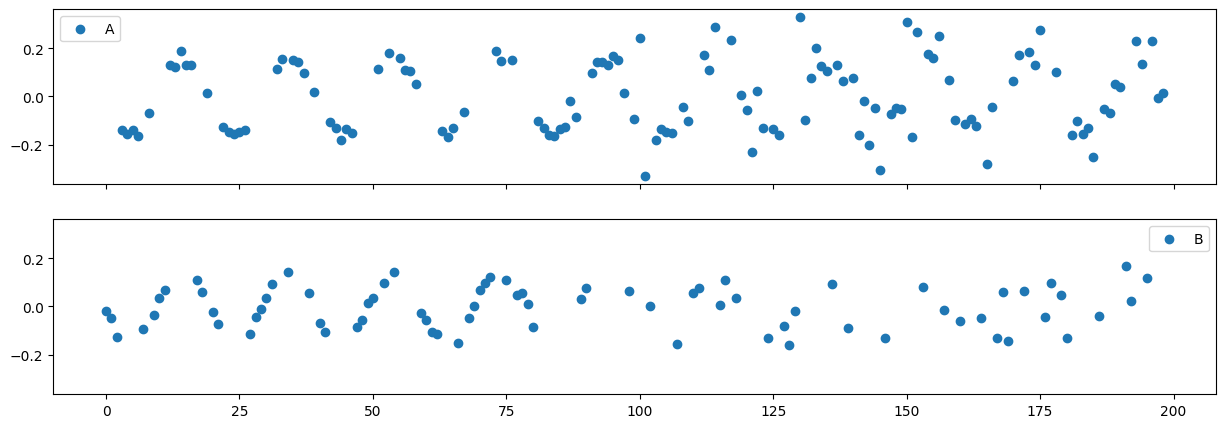

Variance Loss
Balance Loss
Up Count
Down Count


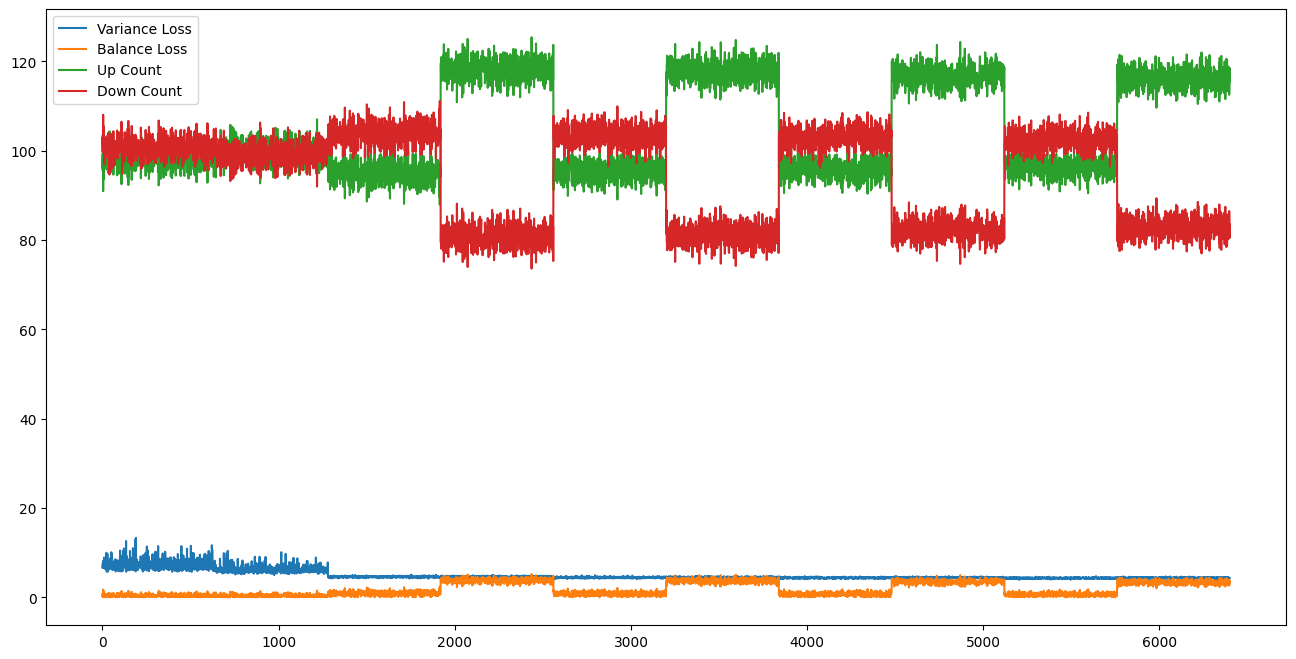

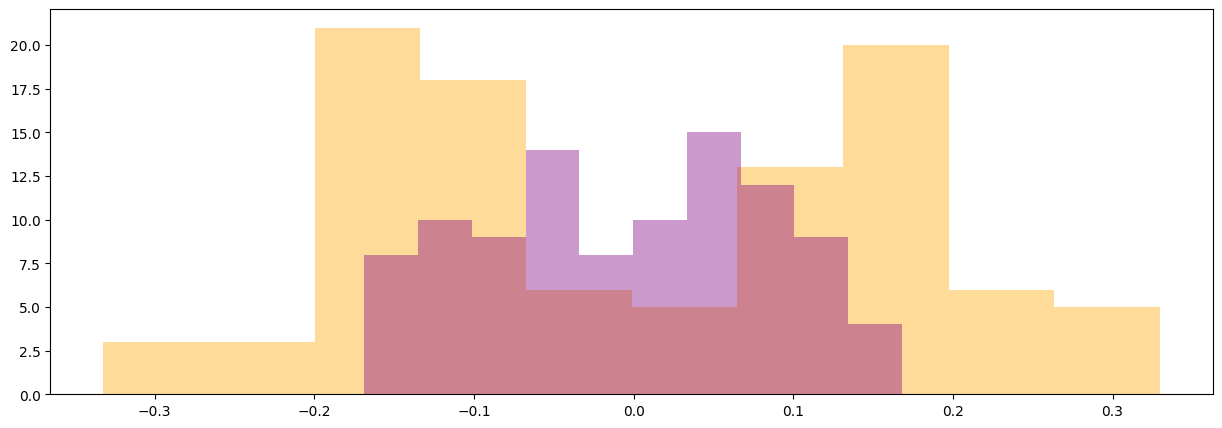

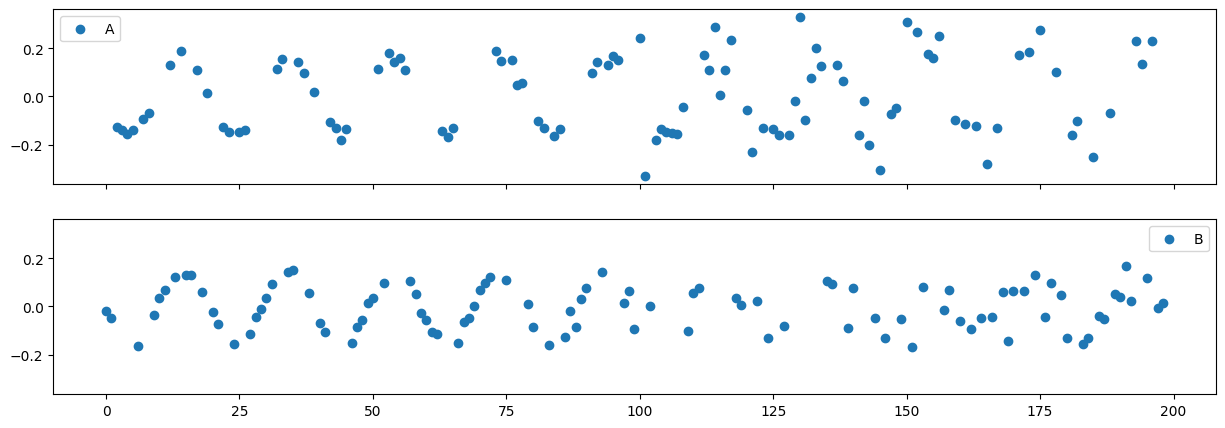

Variance Loss
Balance Loss
Up Count
Down Count


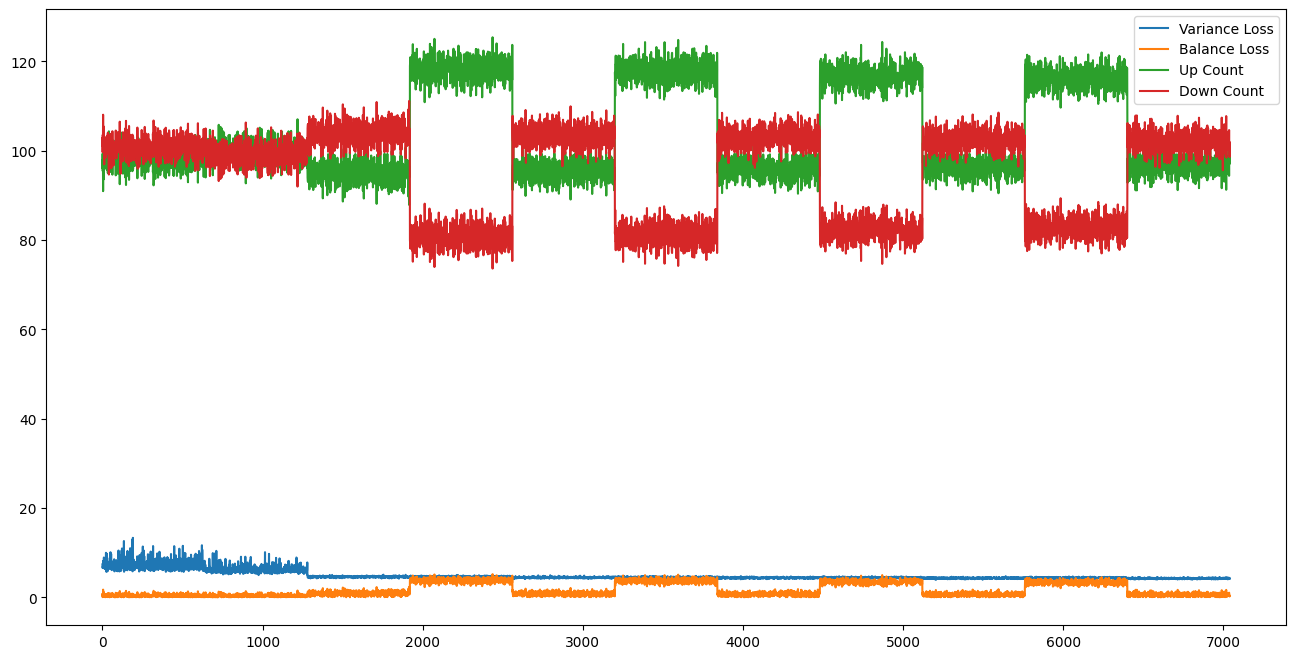

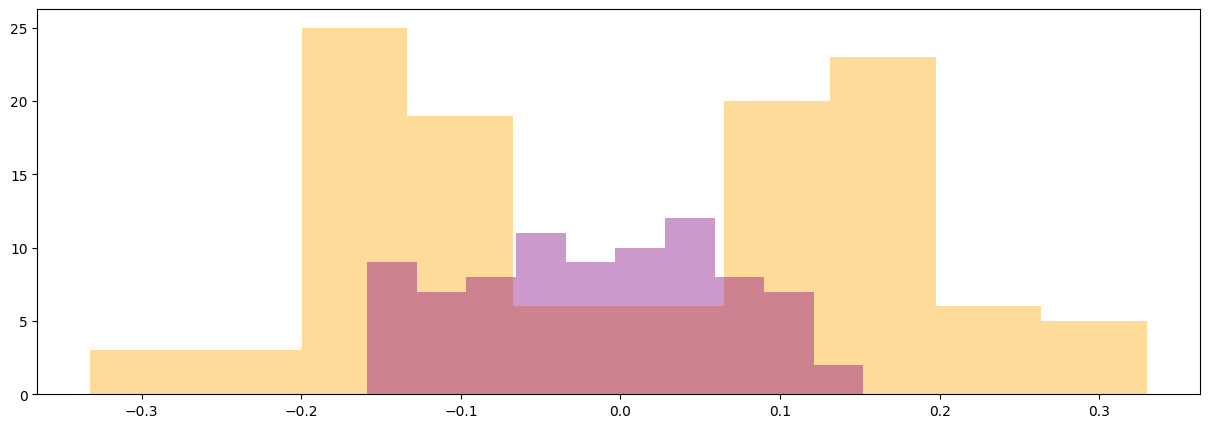

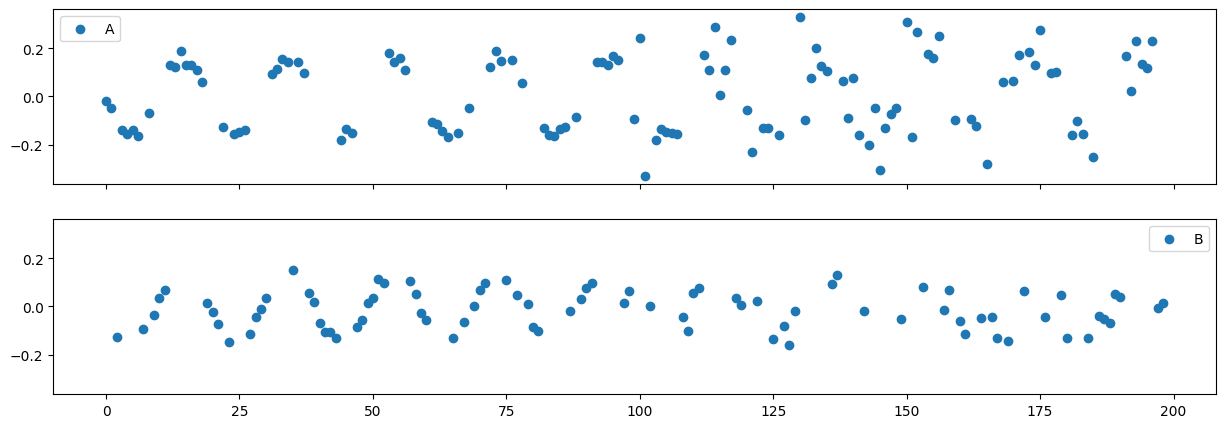

Variance Loss
Balance Loss
Up Count
Down Count


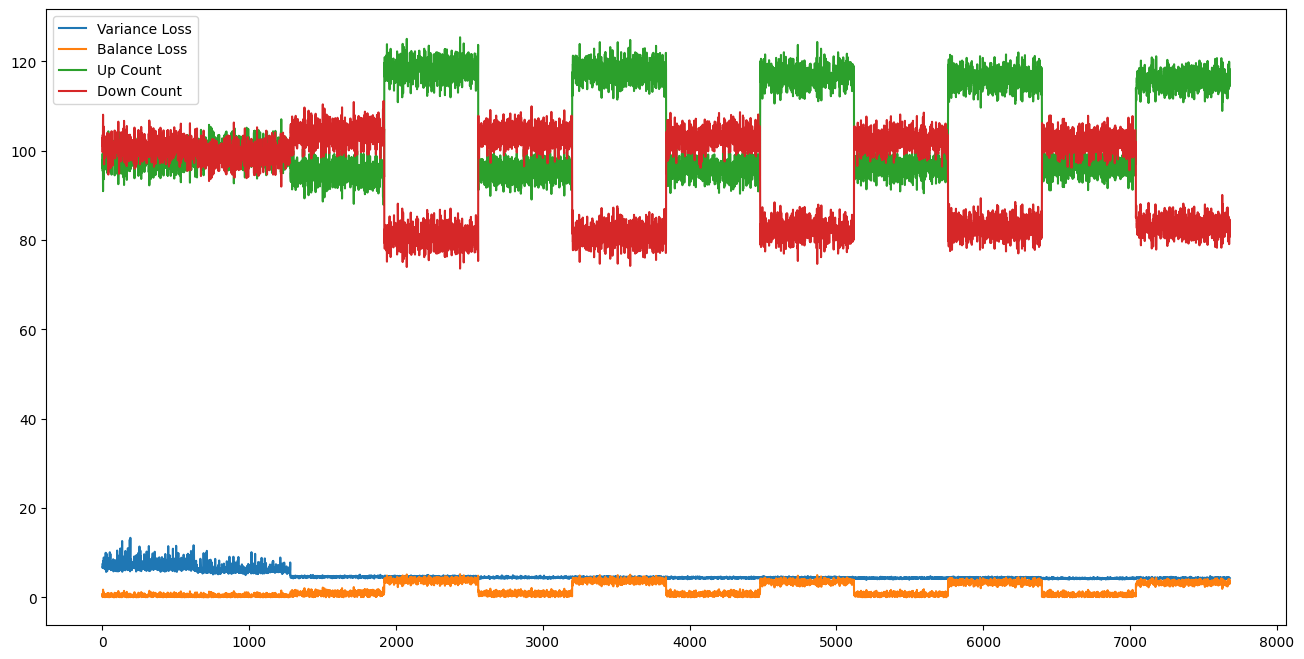

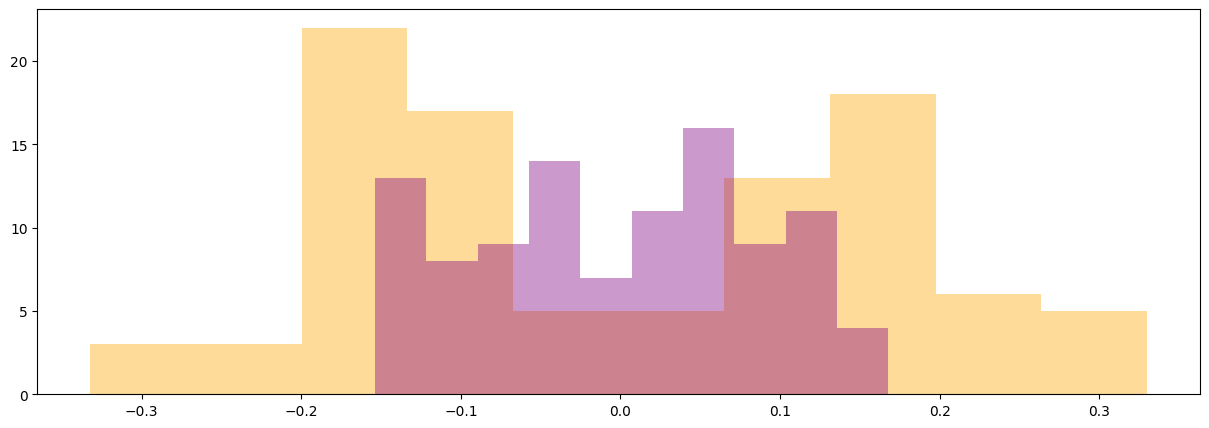

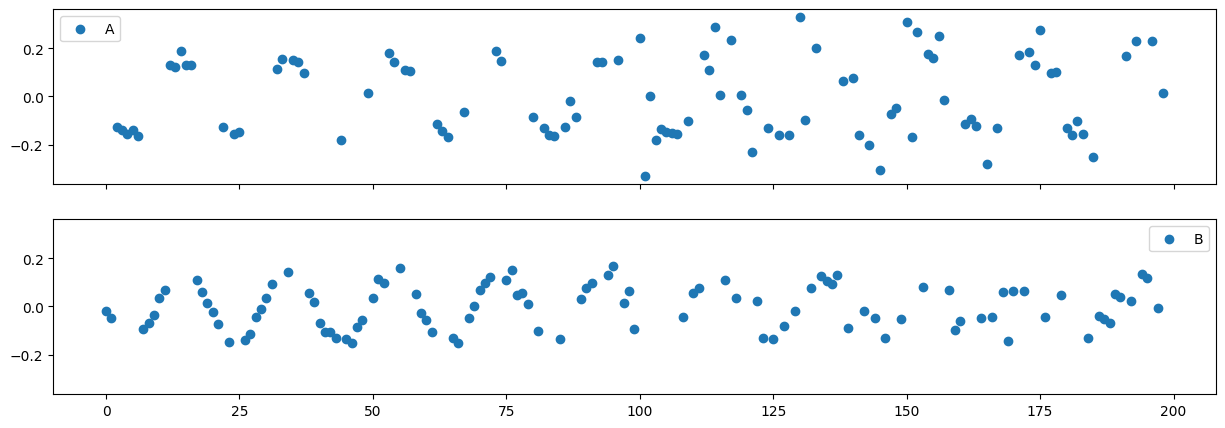

Variance Loss
Balance Loss
Up Count
Down Count


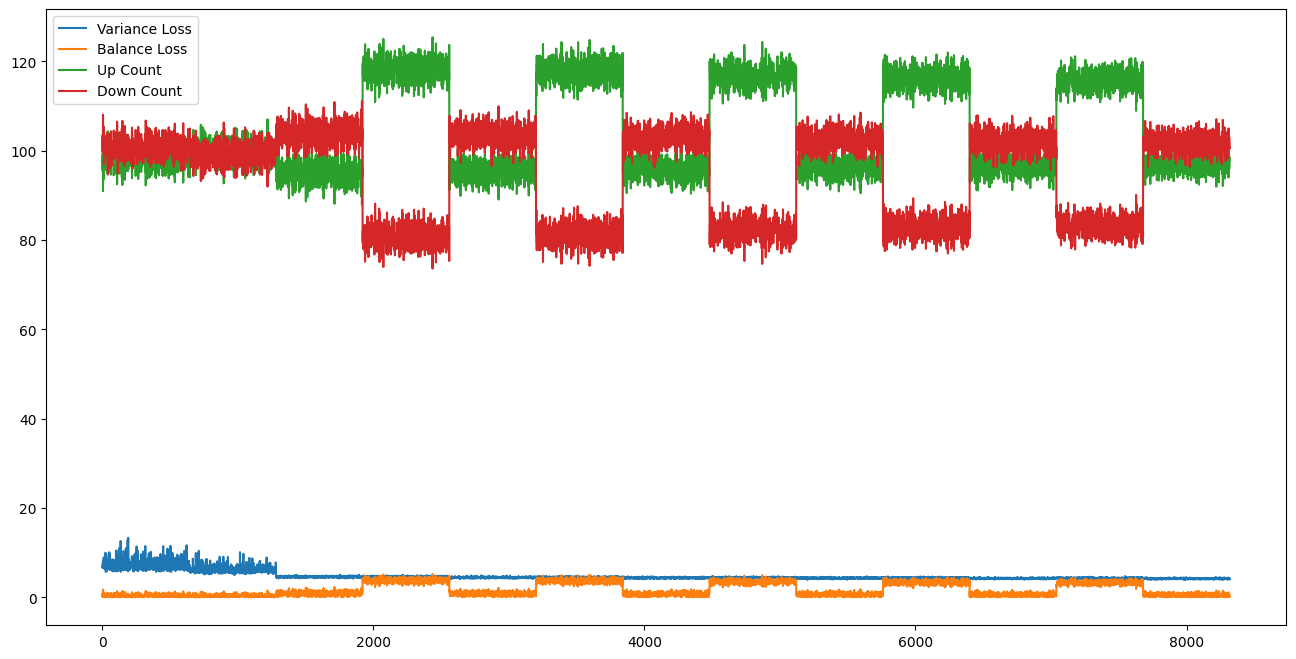

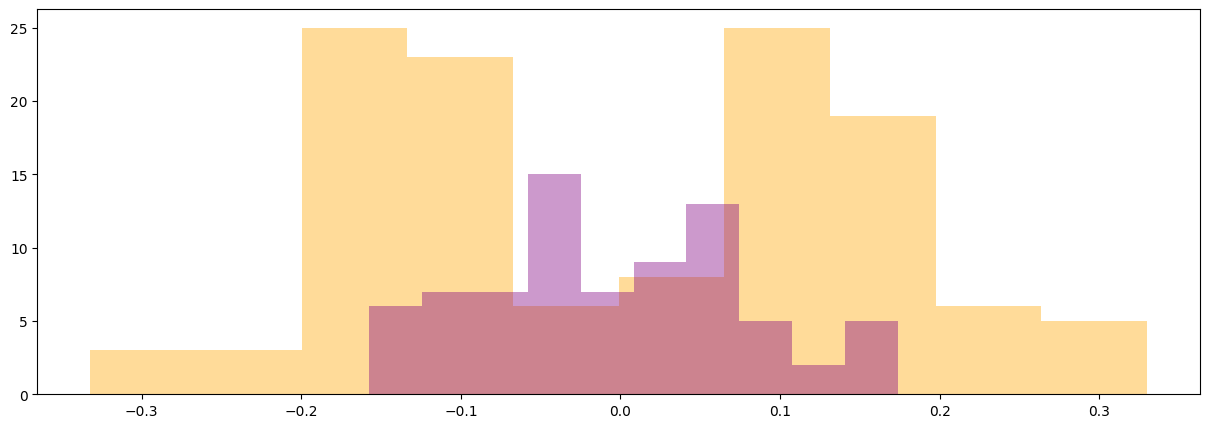

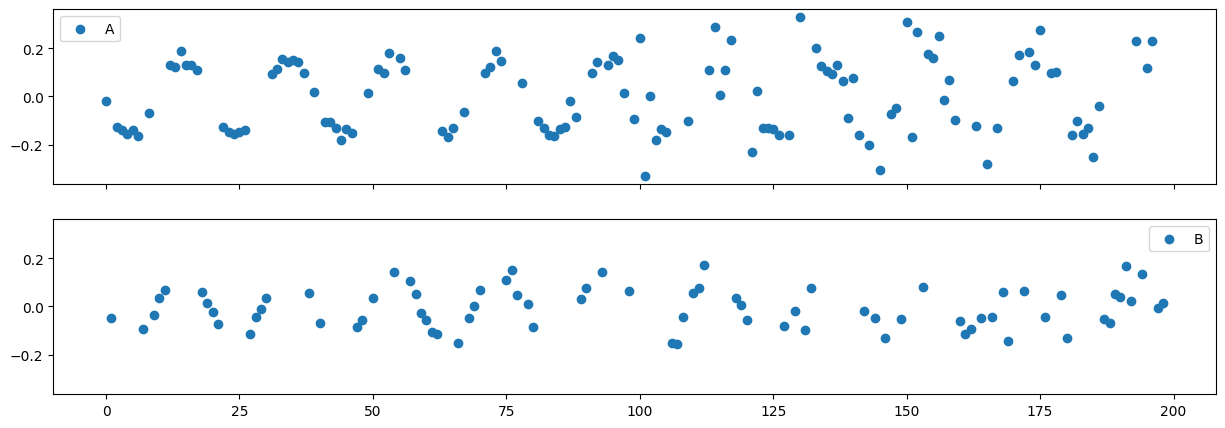

Variance Loss
Balance Loss
Up Count
Down Count


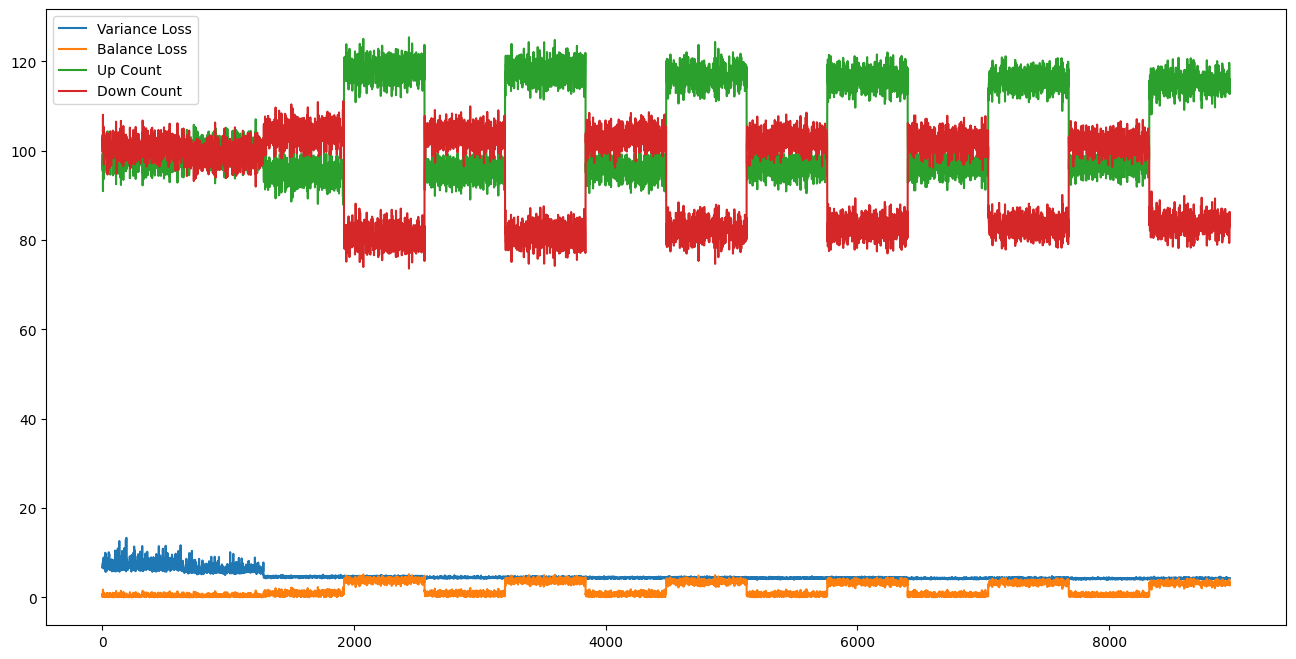

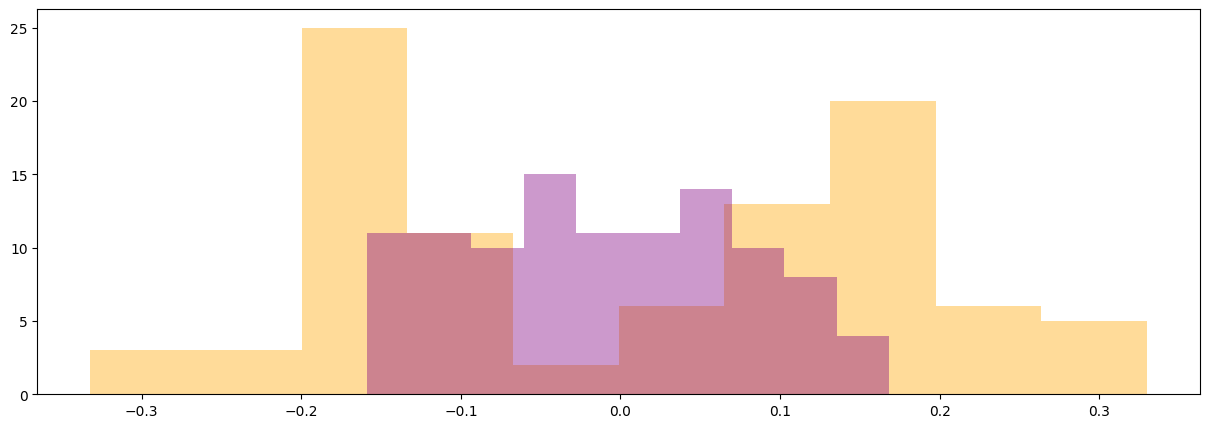

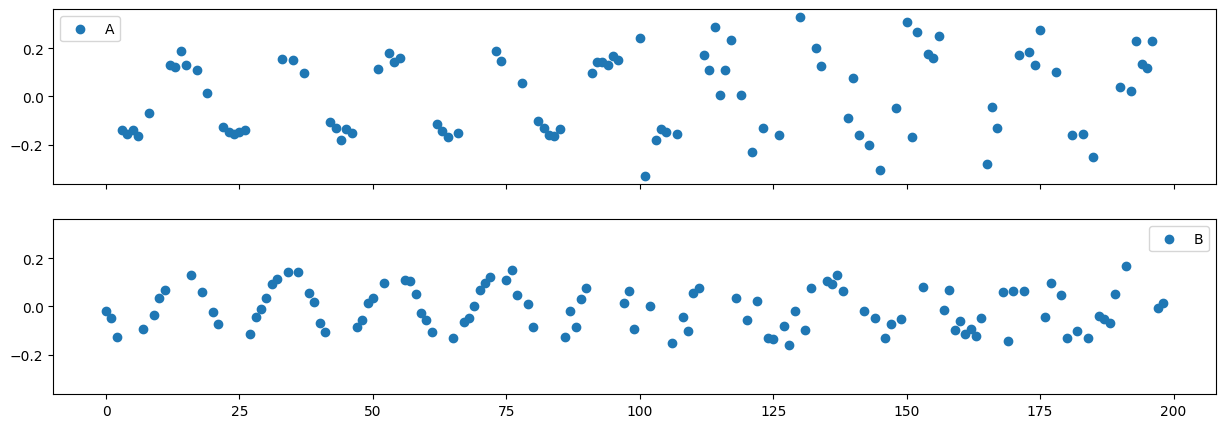

Variance Loss
Balance Loss
Up Count
Down Count


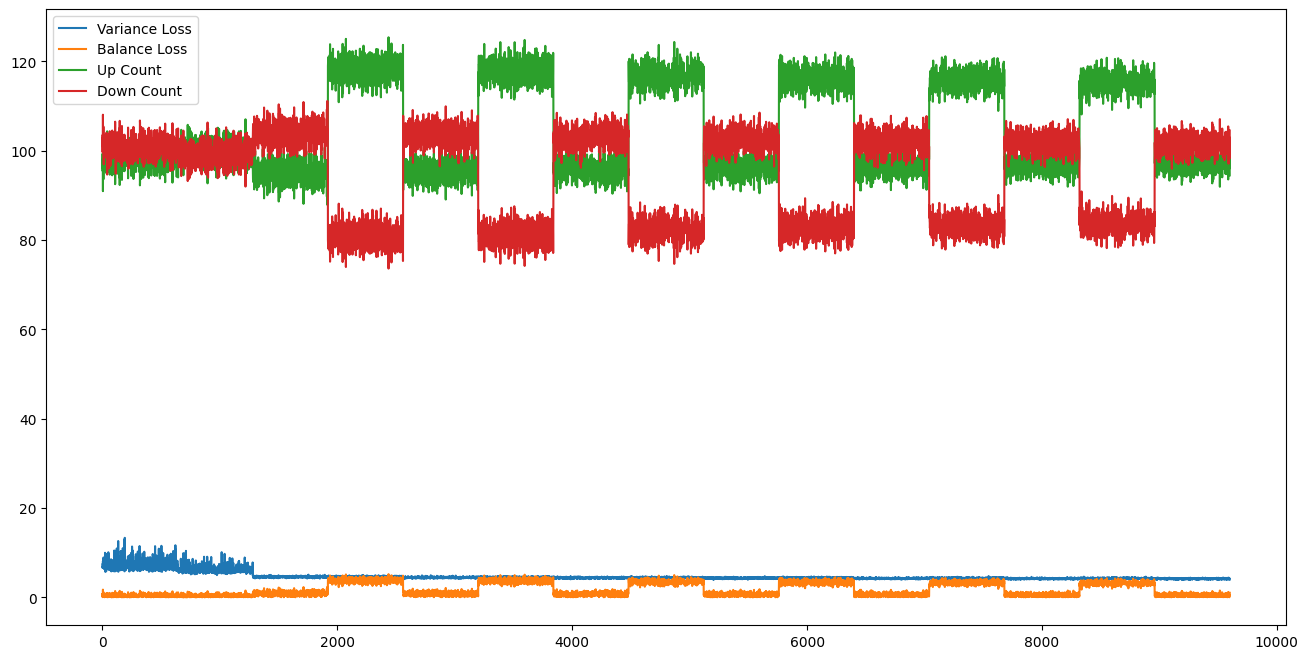

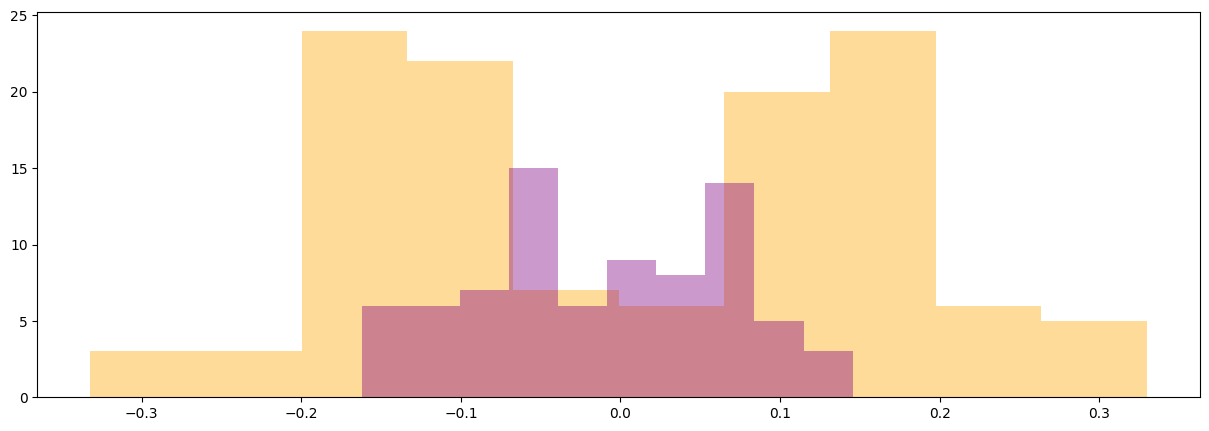

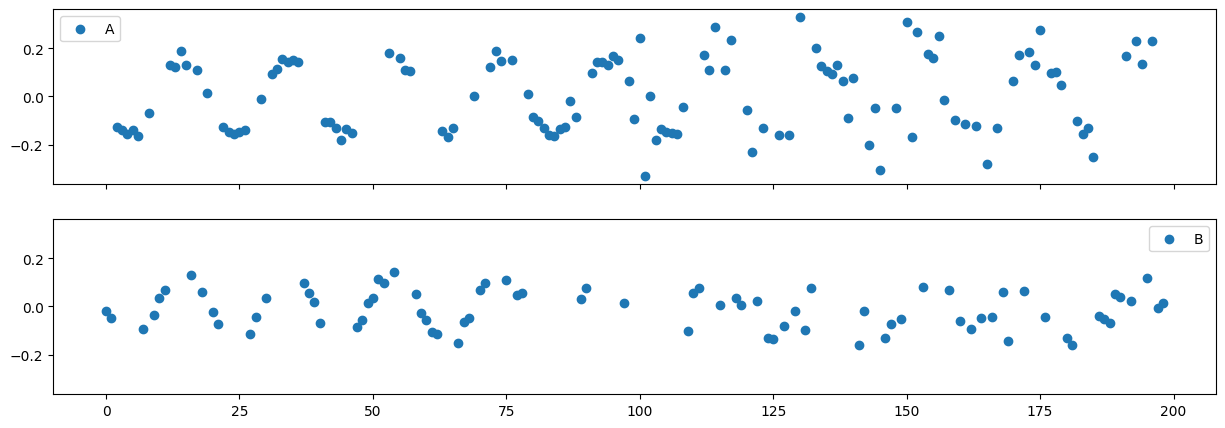

Variance Loss
Balance Loss
Up Count
Down Count


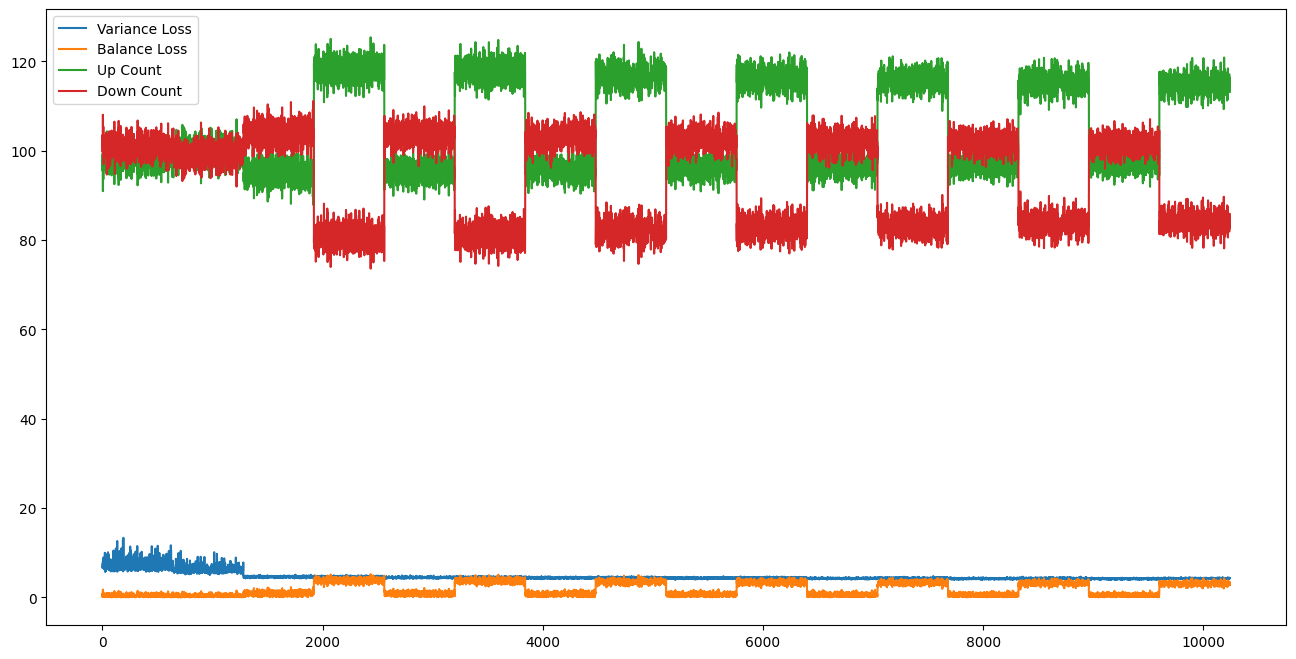

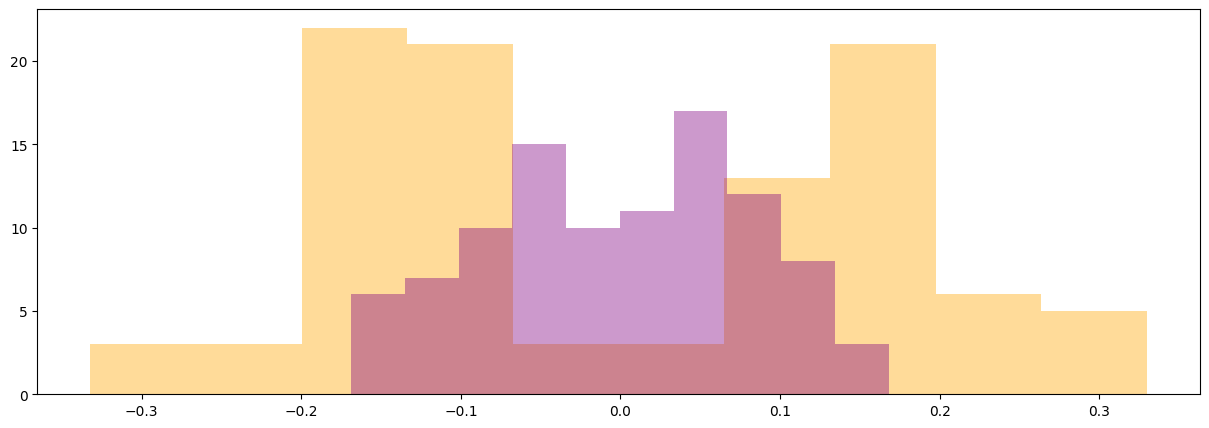

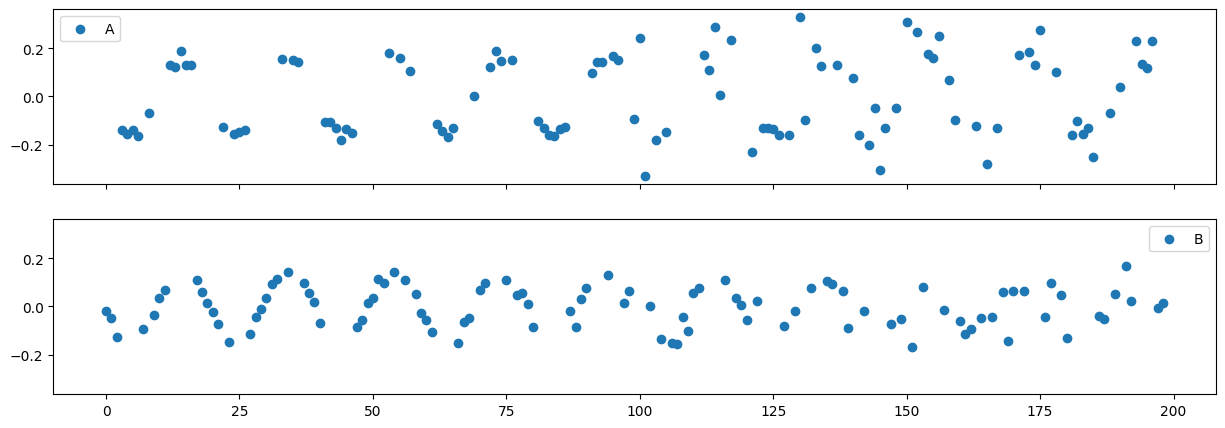

Variance Loss
Balance Loss
Up Count
Down Count


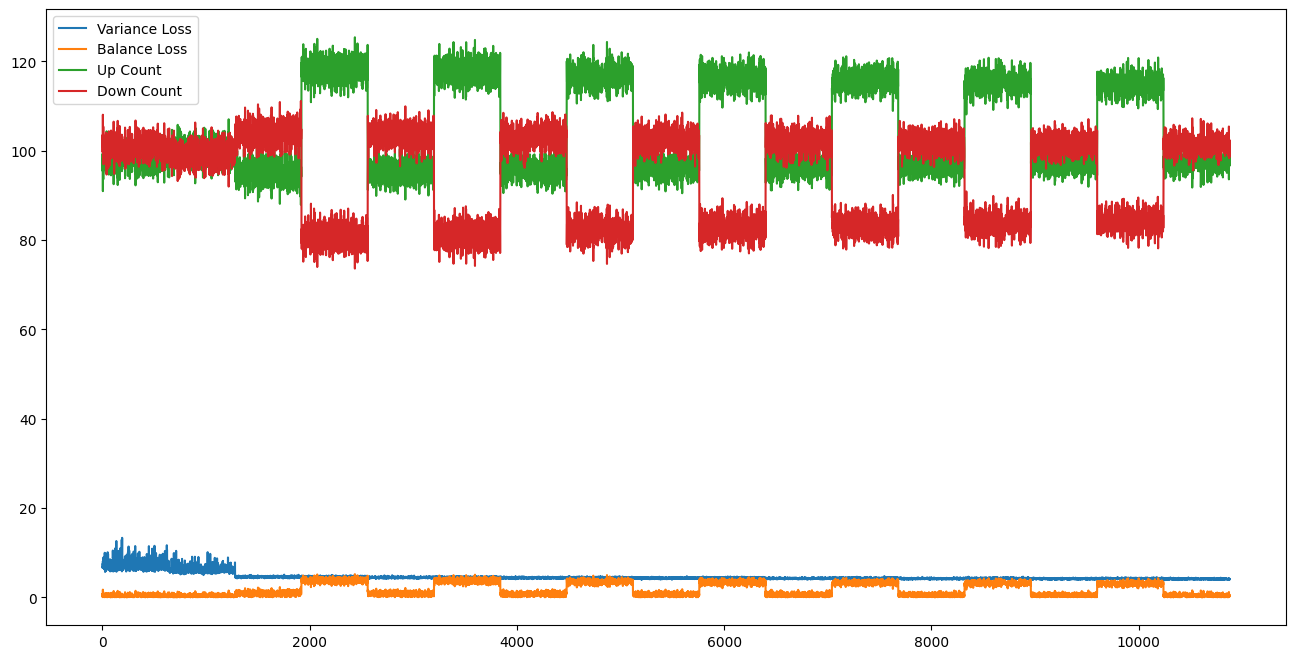

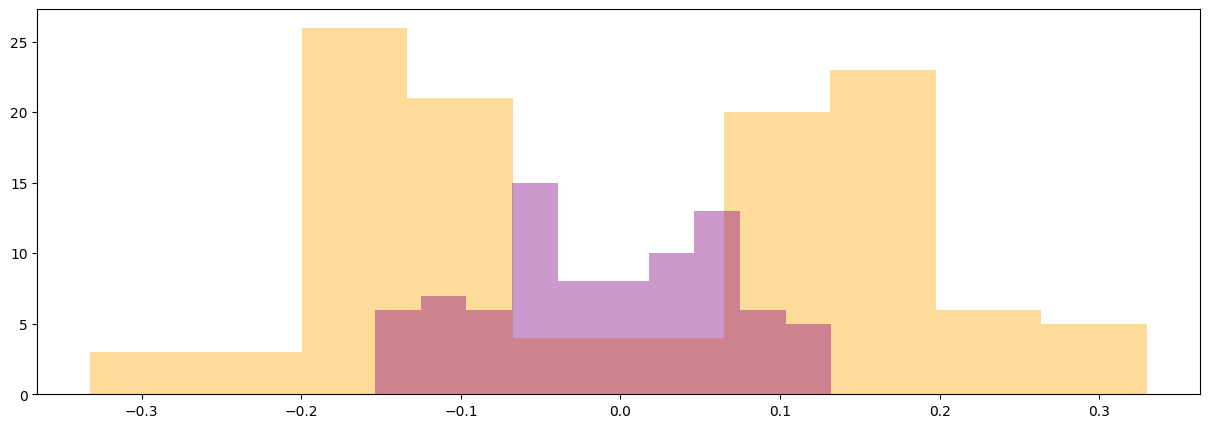

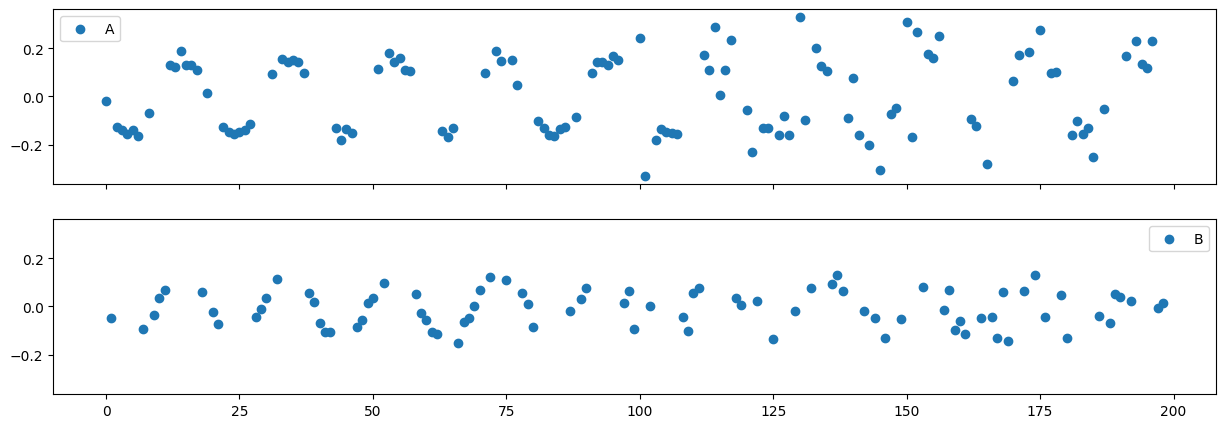

Variance Loss
Balance Loss
Up Count
Down Count


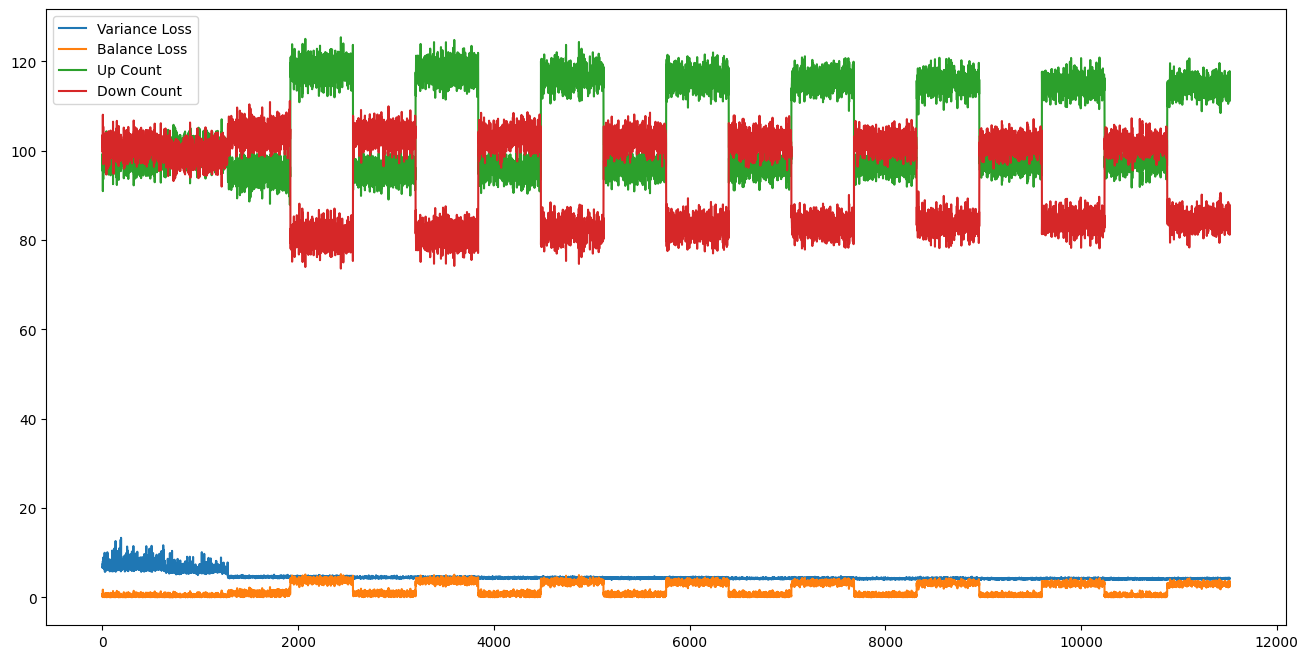

In [ ]:
wave_tensor = torch.from_numpy(np.diff(noise_wave)).requires_grad_(True).float()
# wave_tensor = torch.tensor(wave_tensor, requires_grad=True).float()

plot_steps = 20
epochs = 640

model = SineBinarySeparator(input_dim=wave_tensor.shape[0], dropout_p=.5, lr=1e-5).float()
for _ in range(plot_steps):
    model.train(wave_tensor, epochs=epochs, batch_size=640)
    model.plot_custom_loss()